In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pathlib import Path
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import GridSearchCV
from pathlib import Path
from typing import Dict, Any, List, Optional
warnings.filterwarnings('ignore')

# Load datasets
df_baseline_block_latency = pd.read_csv("baseline/block_count_latency_device.csv")
df_baseline_read_bytes = pd.read_csv("baseline/read_bytes.csv")
df_baseline_write_bytes = pd.read_csv("baseline/write_bytes.csv")

df_cpustress_block_latency = pd.read_csv("cpu stress/block_count_latency_device.csv")
df_cpustress_read_bytes = pd.read_csv("cpu stress/read_bytes.csv")
df_cpustress_write_bytes = pd.read_csv("cpu stress/write_bytes.csv")

df_delay_block_latency = pd.read_csv("delay/block_count_latency_device.csv")
df_delay_read_bytes = pd.read_csv("delay/read_bytes.csv")
df_delay_write_bytes = pd.read_csv("delay/write_bytes.csv")

df_memstress_block_latency = pd.read_csv("mem stress/block_count_latency_device.csv")
df_memstress_read_bytes = pd.read_csv("mem stress/read_bytes.csv")
df_memstress_write_bytes = pd.read_csv("mem stress/write_bytes.csv")

df_netloss_block_latency = pd.read_csv("netloss/block_count_latency_device.csv")
df_netloss_read_bytes = pd.read_csv("netloss/read_bytes.csv")
df_netloss_write_bytes = pd.read_csv("netloss/write_bytes.csv")

# Add source labels
for df, source in [(df_baseline_block_latency, "BASELINE"), (df_baseline_read_bytes, "BASELINE"), (df_baseline_write_bytes, "BASELINE"),
                   (df_cpustress_block_latency, "CPU_STRESS"), (df_cpustress_read_bytes, "CPU_STRESS"), (df_cpustress_write_bytes, "CPU_STRESS"),
                   (df_delay_block_latency, "DELAY"), (df_delay_read_bytes, "DELAY"), (df_delay_write_bytes, "DELAY"),
                   (df_memstress_block_latency, "MEM_STRESS"), (df_memstress_read_bytes, "MEM_STRESS"), (df_memstress_write_bytes, "MEM_STRESS"),
                   (df_netloss_block_latency, "NET_LOSS"), (df_netloss_read_bytes, "NET_LOSS"), (df_netloss_write_bytes, "NET_LOSS")]:
    df["source"] = source

# Convert to datetime
all_dfs = [df_baseline_block_latency, df_baseline_read_bytes, df_baseline_write_bytes,
           df_cpustress_block_latency, df_cpustress_read_bytes, df_cpustress_write_bytes,
           df_delay_block_latency, df_delay_read_bytes, df_delay_write_bytes,
           df_memstress_block_latency, df_memstress_read_bytes, df_memstress_write_bytes,
           df_netloss_block_latency, df_netloss_read_bytes, df_netloss_write_bytes]

for df in all_dfs:
    df["Time"] = pd.to_datetime(df["Time"])

# Synchronize timelines
time_offset = df_baseline_block_latency["Time"].min()

for df_group in [(df_cpustress_block_latency, df_cpustress_read_bytes, df_cpustress_write_bytes),
                 (df_delay_block_latency, df_delay_read_bytes, df_delay_write_bytes),
                 (df_memstress_block_latency, df_memstress_read_bytes, df_memstress_write_bytes),
                 (df_netloss_block_latency, df_netloss_read_bytes, df_netloss_write_bytes)]:
    offset = time_offset - df_group[0]["Time"].min()
    for df in df_group:
        df["Time"] += offset

# Convert to minutes
for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# Dataset structure
all_datasets = {
    'BlockLatency': {
        'baseline': df_baseline_block_latency,
        'cpu_stress': df_cpustress_block_latency,
        'delay': df_delay_block_latency,
        'mem_stress': df_memstress_block_latency,
        'net_loss': df_netloss_block_latency,
    },
    'ReadBytes': {
        'baseline': df_baseline_read_bytes,
        'cpu_stress': df_cpustress_read_bytes,
        'delay': df_delay_read_bytes,
        'mem_stress': df_memstress_read_bytes,
        'net_loss': df_netloss_read_bytes,
    },
    'WriteBytes': {
        'baseline': df_baseline_write_bytes,
        'cpu_stress': df_cpustress_write_bytes,
        'delay': df_delay_write_bytes,
        'mem_stress': df_memstress_write_bytes,
        'net_loss': df_netloss_write_bytes,
    }
}

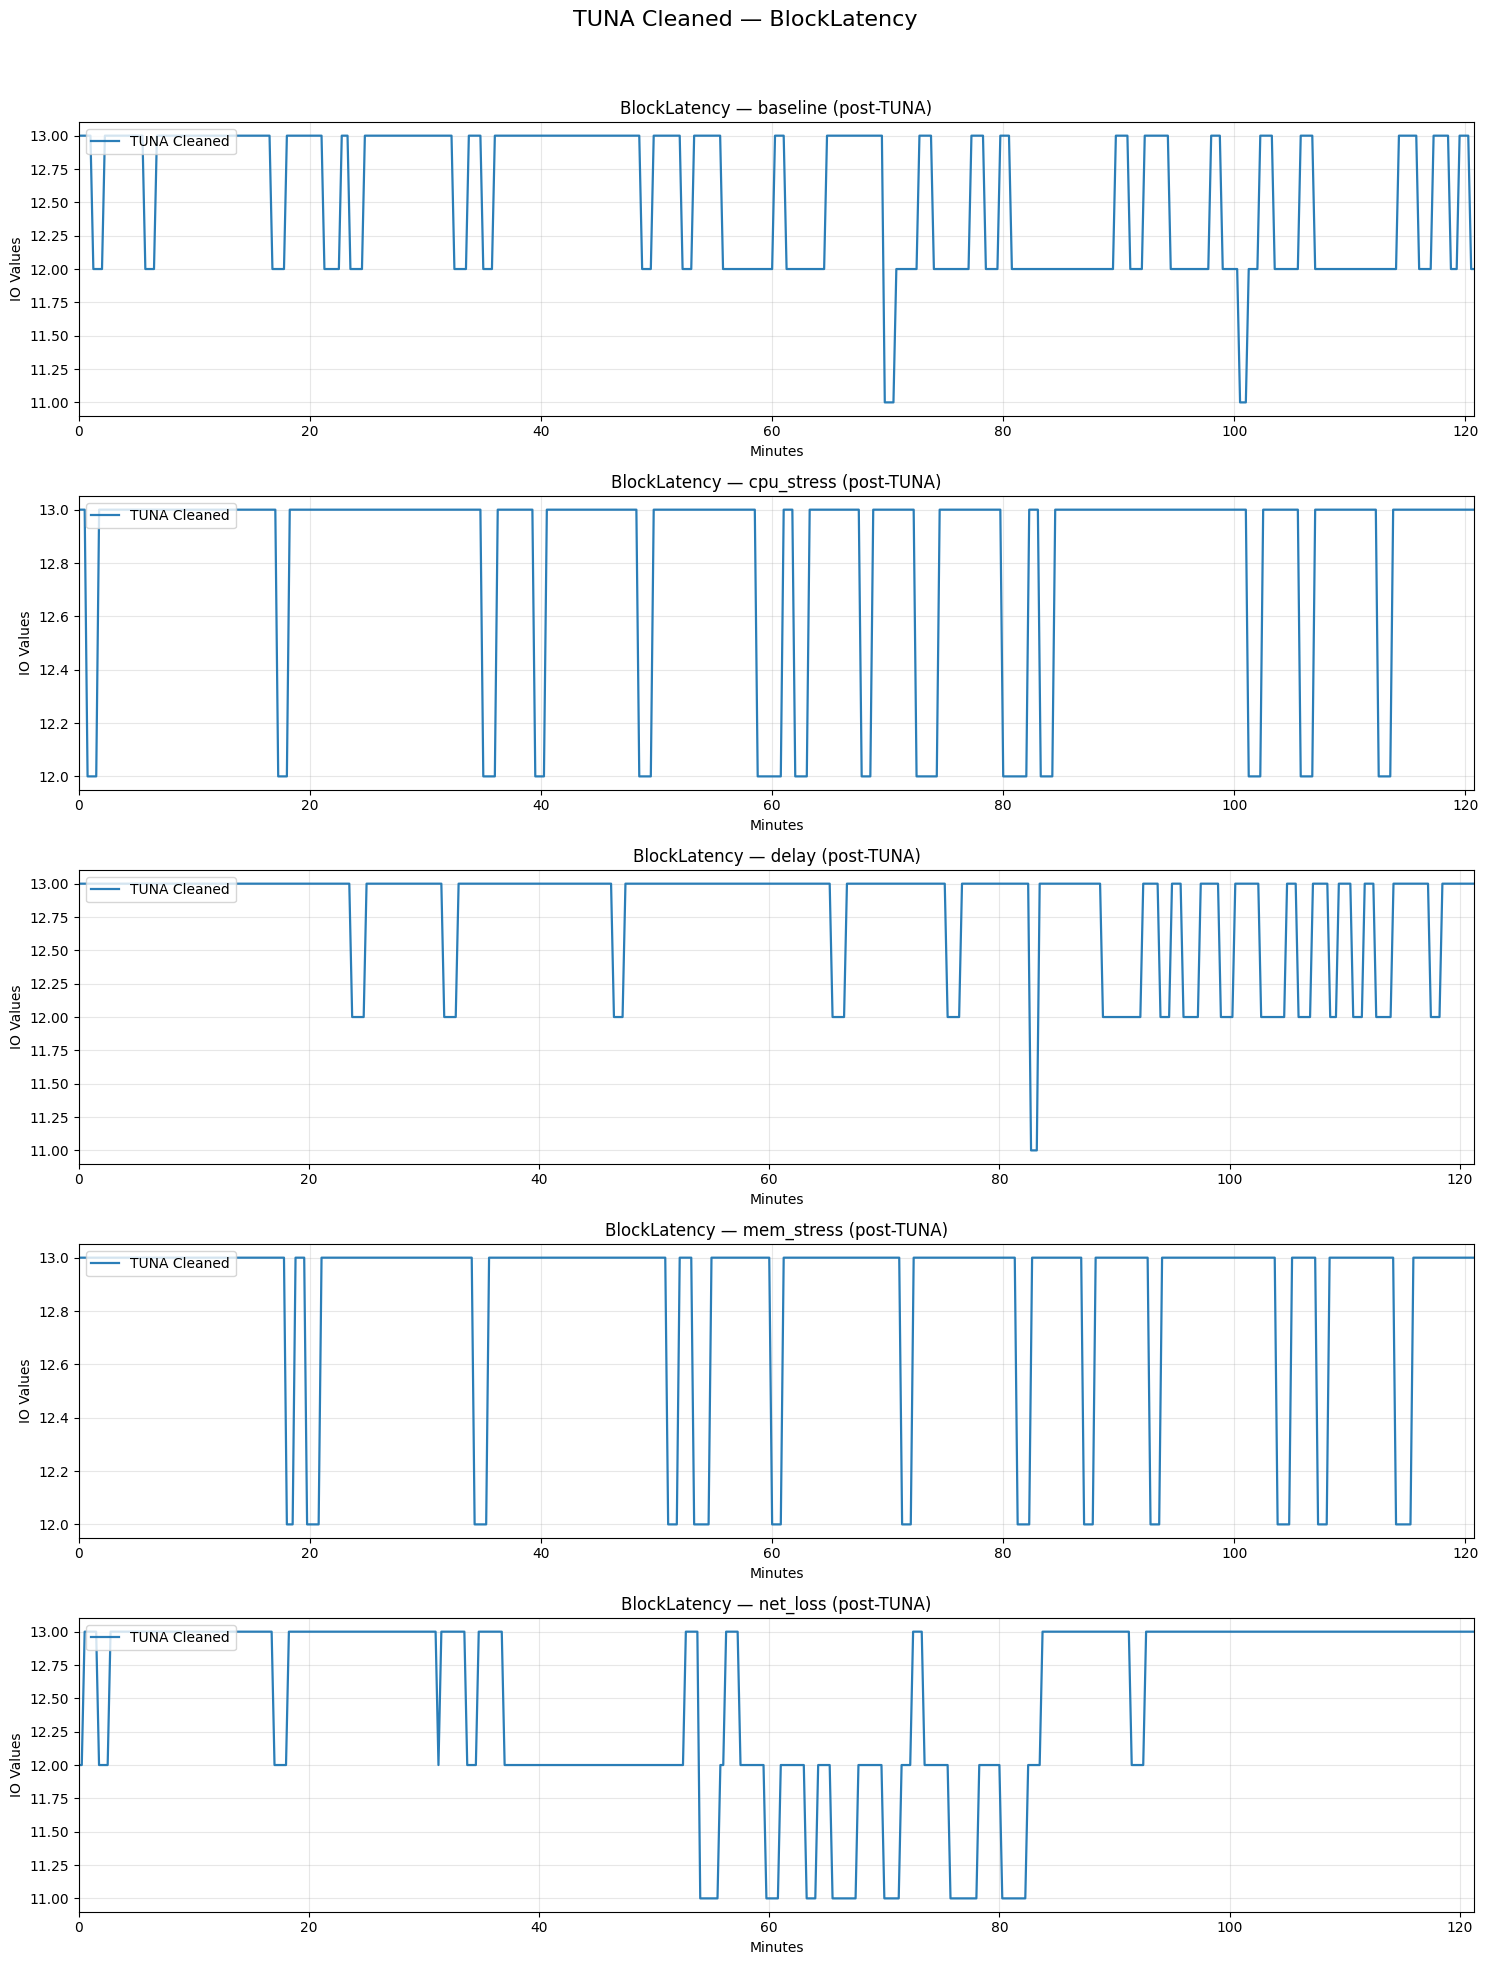

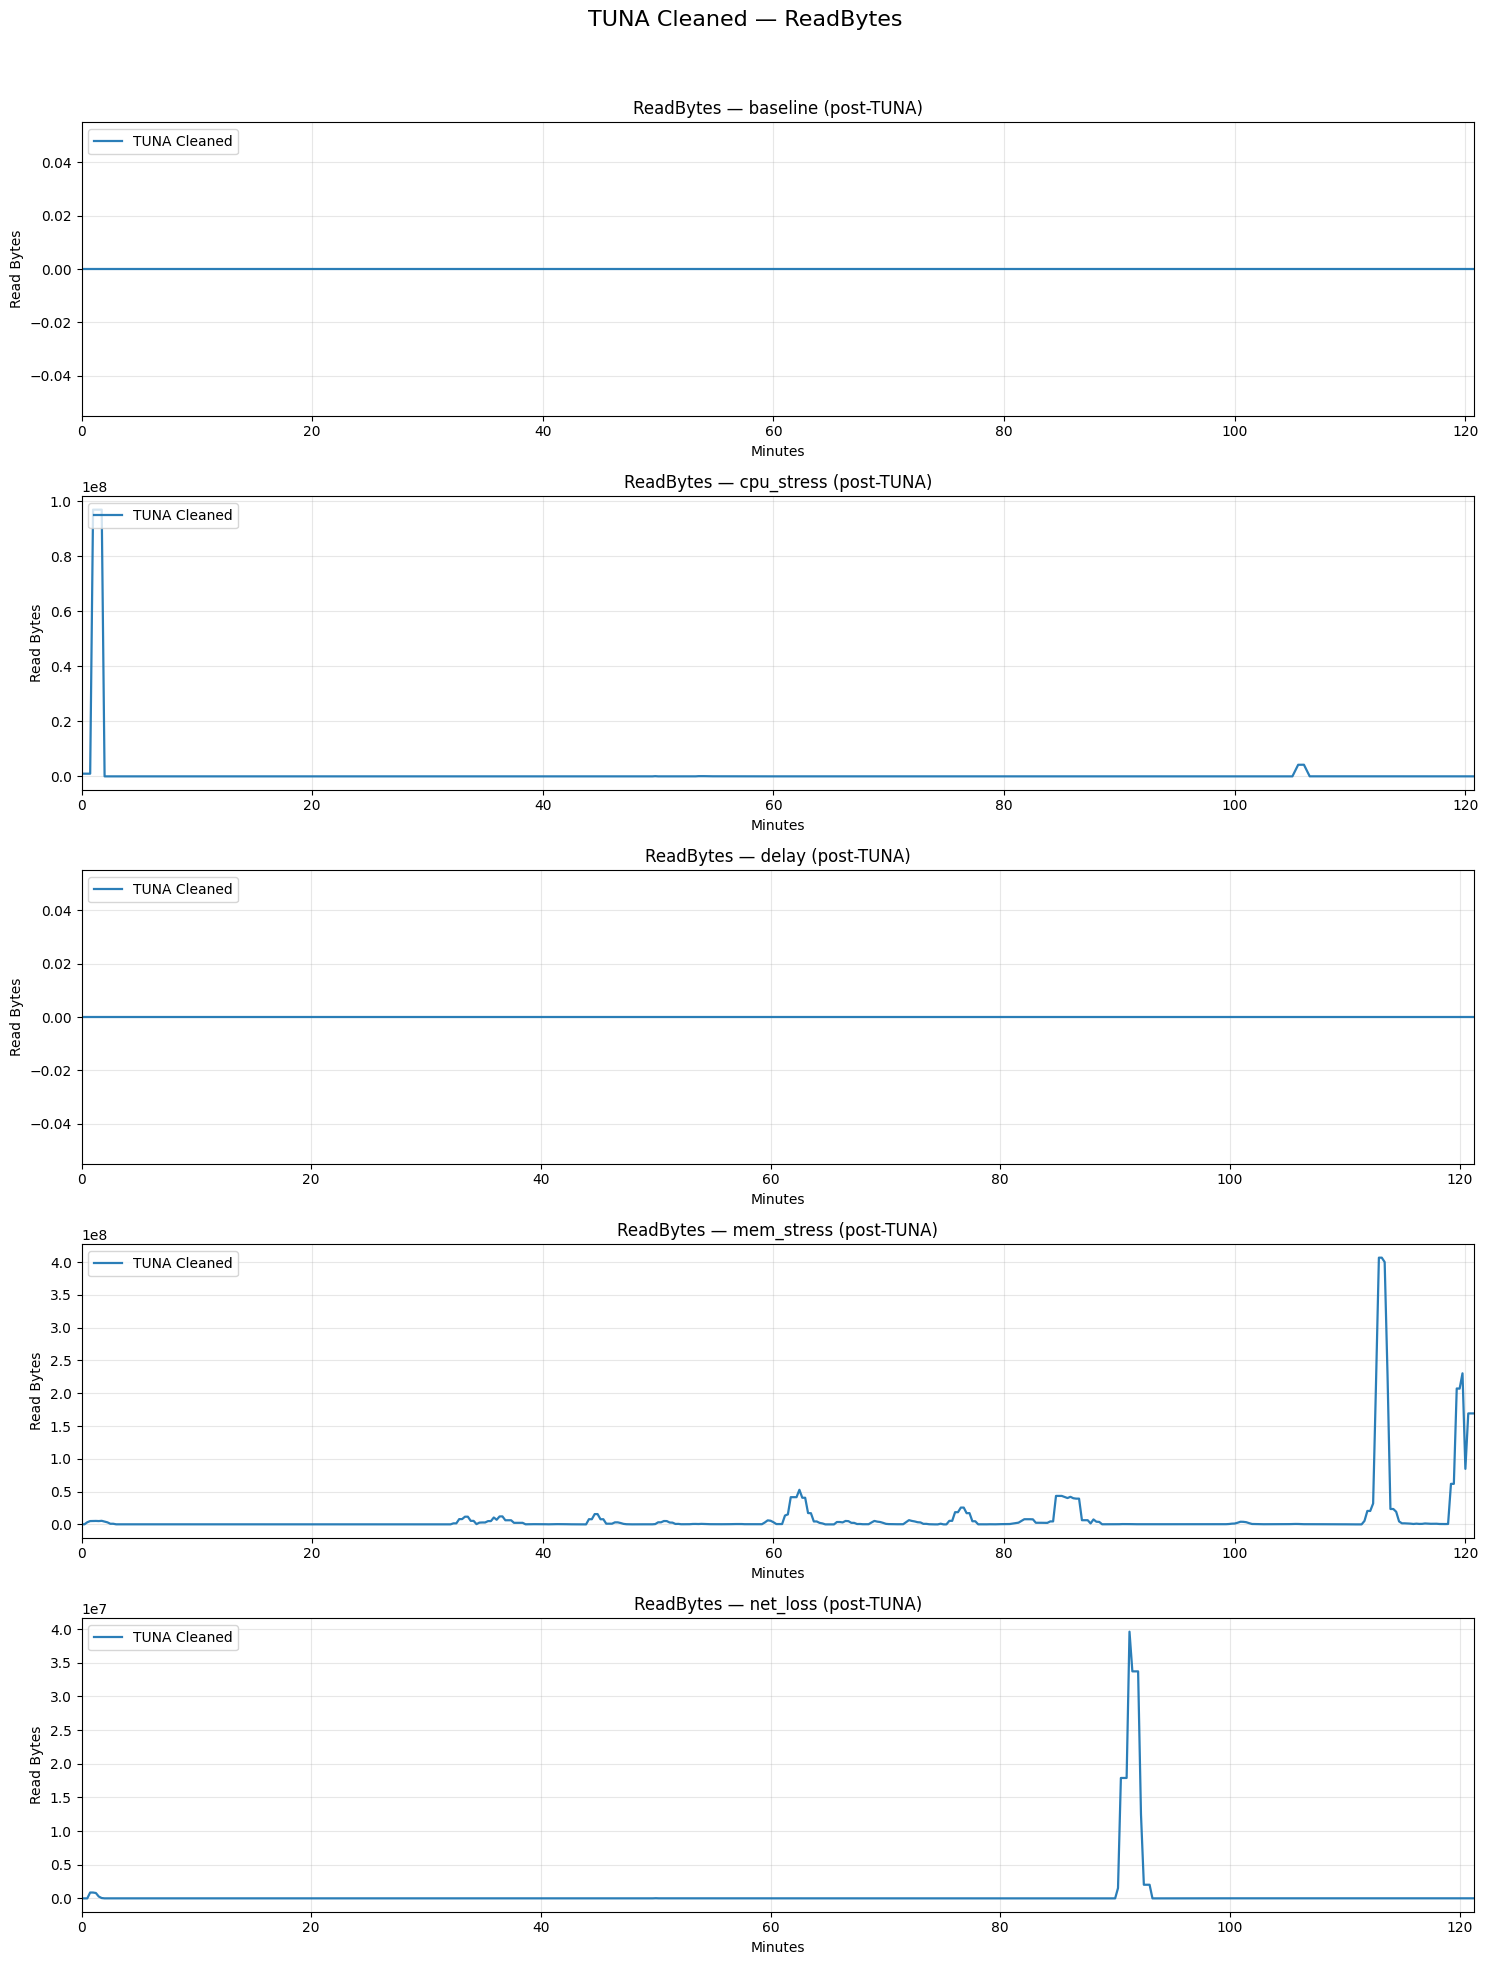

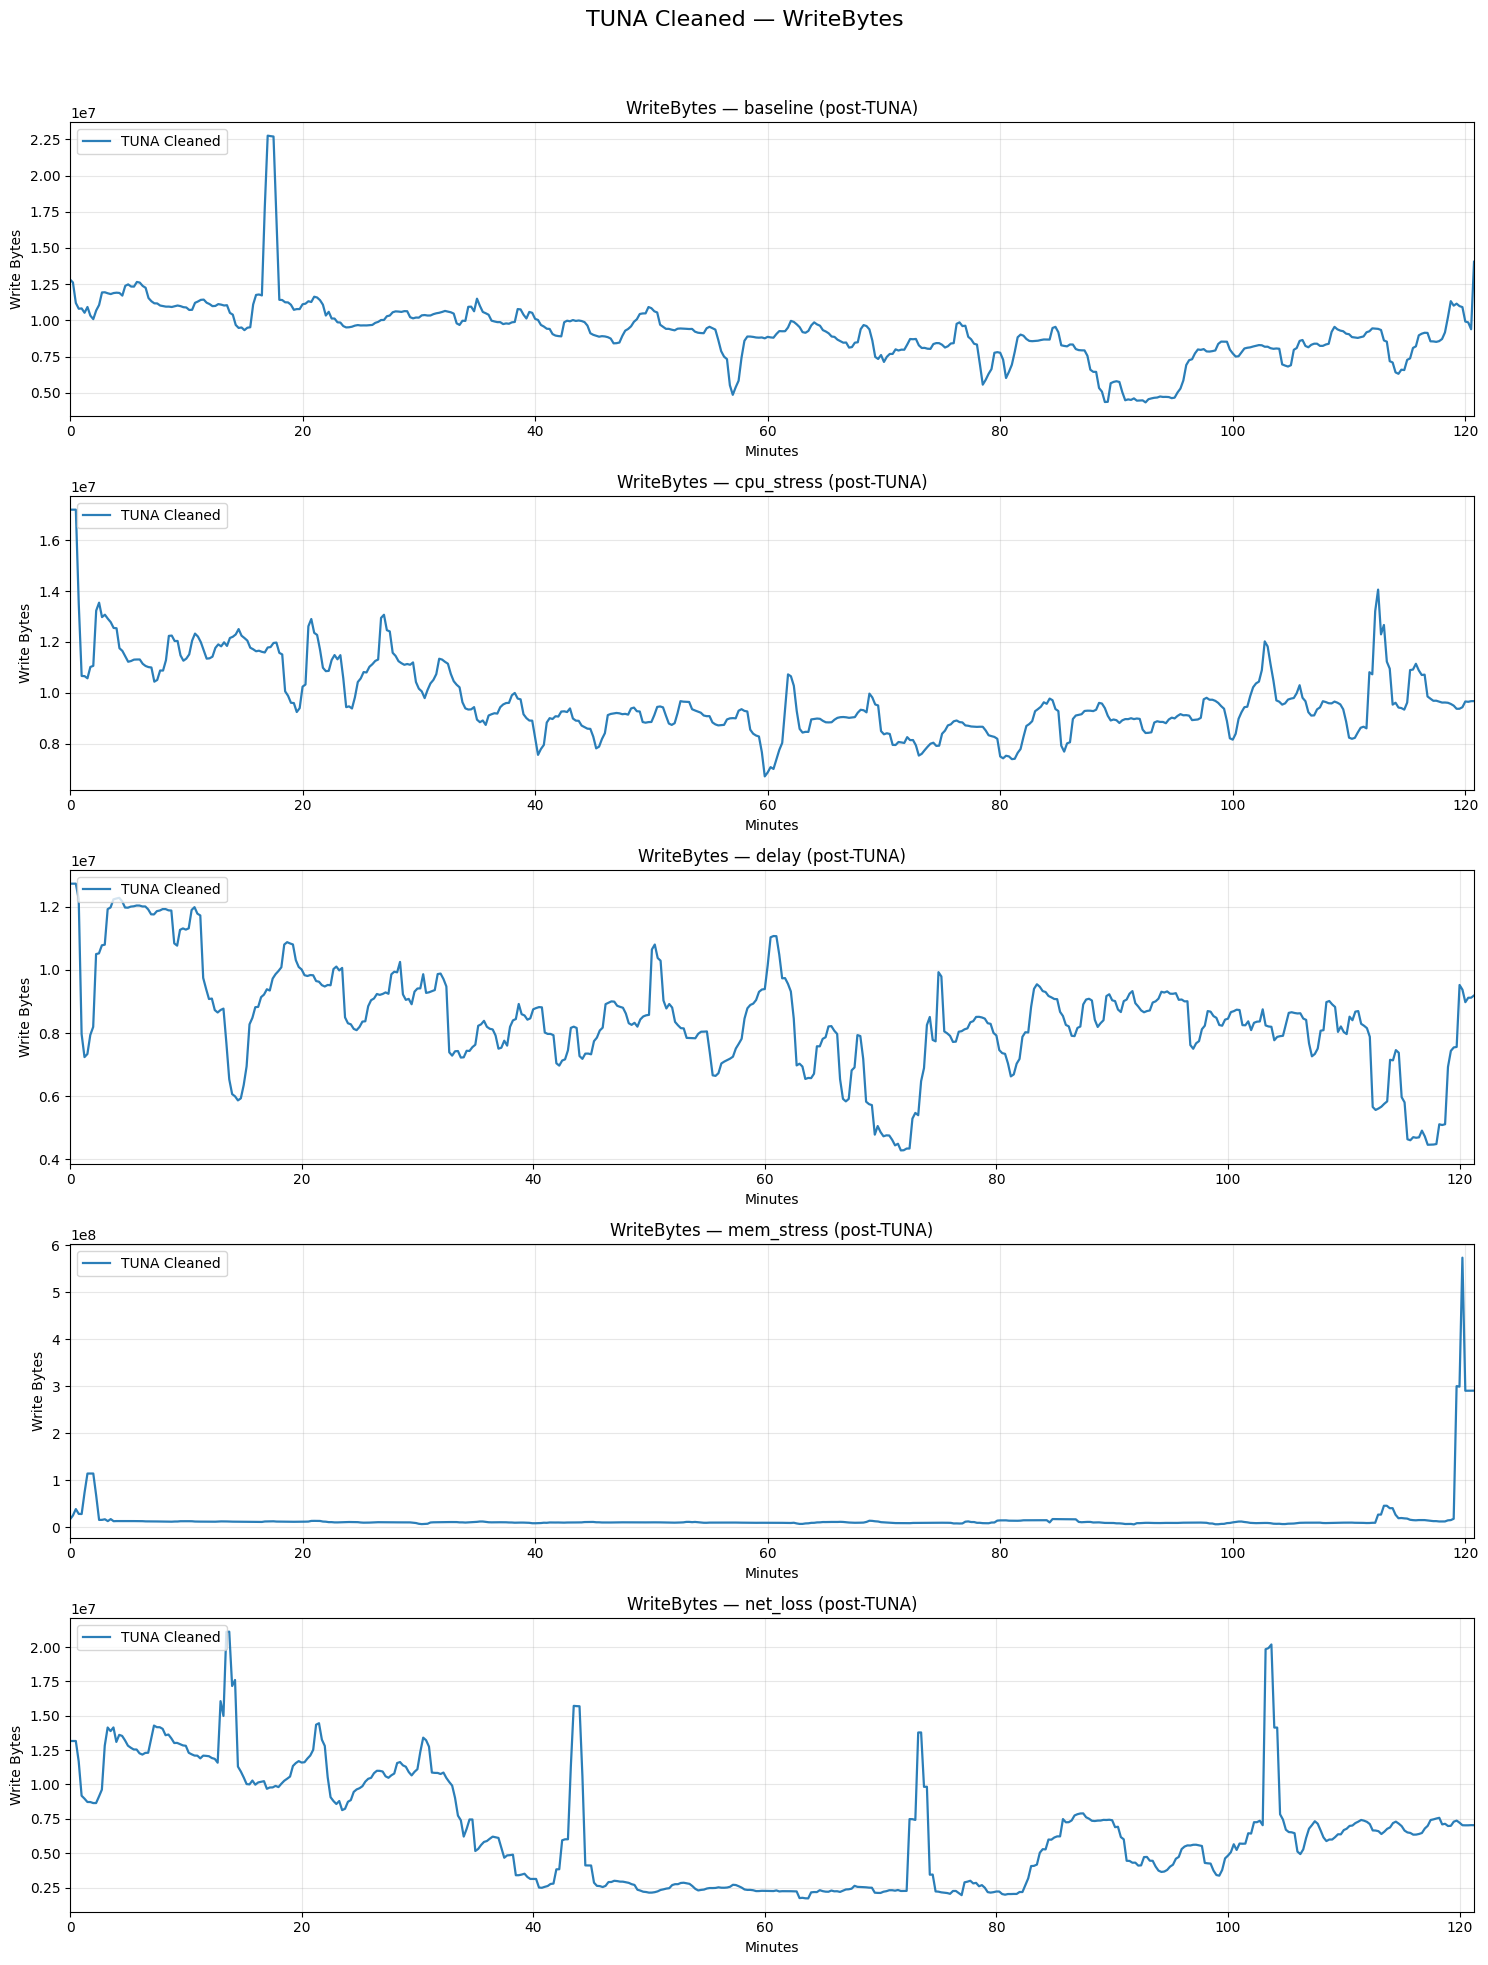

In [5]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


# ---------------------------
# Parametri + Outlier detector
# ---------------------------
def get_tuna_parameters_io(metric_name, experiment_type):
    """Parametri TUNA per metriche IO (consistenti per famiglia)."""
    m = metric_name.lower()
    if "blockcount" in m:
        window_size = 20
        threshold = 1.5
    elif "readbytes" in m:
        window_size = 8
        threshold = 0.6
    elif "writebytes" in m:
        window_size = 16
        threshold = 1.0
    else:
        window_size = 12
        threshold = 0.8

    return {
        "window_size": window_size,
        "threshold": threshold,
        "min_absolute_range_factor": 0.2,
        "penalty_factor": 0.5,
        "lookback_window": 12,
    }


def detect_outliers_tuna_io(timeseries, metric_name="", experiment_type=""):
    """Rilevazione outlier TUNA per IO (relative range + guardrail assoluto)."""
    outlier_mask = np.zeros(len(timeseries), dtype=bool)
    params = get_tuna_parameters_io(metric_name, experiment_type)

    W = params["window_size"]
    tau = params["threshold"]
    eta = params["min_absolute_range_factor"] * float(np.std(timeseries) or 0.0)

    for start in range(0, len(timeseries) - W + 1):
        w = timeseries[start : start + W]
        mu = float(np.mean(w))
        r_abs = float(np.max(w) - np.min(w))

        # euristiche semplici per IO “vuoto” o livello troppo basso
        if np.mean(w == 0) > 0.8:
            continue
        if mu < 100:
            continue

        if mu > 0:
            r_rel = r_abs / mu
            if (r_rel > tau) and (r_abs > eta):
                w_max = np.max(w)
                w_min = np.min(w)
                # marca solo max/min della finestra
                for j in range(W):
                    idx = start + j
                    if timeseries[idx] == w_max or timeseries[idx] == w_min:
                        outlier_mask[idx] = True

    return outlier_mask


# ---------------------------
# Penalty (baseline locale)
# ---------------------------
def _local_baseline_io(timeseries, stable_mask, i, L):
    """Baseline locale robusta: backward -> forward -> globale."""
    # backward
    s = max(0, i - L)
    ws = timeseries[s:i]
    ms = stable_mask[s:i]
    vals = ws[ms]
    if len(vals) >= 3:
        return float(np.median(vals))
    if len(vals) >= 1:
        return float(np.mean(vals))

    # forward
    e = min(len(timeseries), i + L)
    wf = timeseries[i + 1 : e]
    mf = stable_mask[i + 1 : e]
    vals = wf[mf]
    if len(vals) >= 3:
        return float(np.median(vals))
    if len(vals) >= 1:
        return float(np.mean(vals))

    # globale
    vals = timeseries[stable_mask]
    if len(vals) > 0:
        return float(np.median(vals))
    return float(np.median(timeseries))


def apply_penalty_io(timeseries, outlier_mask, metric_name="", experiment_type=""):
    """Shift verso baseline locale con fattore di penalità."""
    params = get_tuna_parameters_io(metric_name, experiment_type)
    gamma = params["penalty_factor"]
    L = params["lookback_window"]

    series = timeseries.copy().astype(float)
    stable_mask = ~outlier_mask

    for i in range(len(series)):
        if outlier_mask[i]:
            b = _local_baseline_io(series, stable_mask, i, L)
            dev = series[i] - b
            series[i] = b + gamma * dev

    return series


# ---------------------------
# Feature ML + applicazione
# ---------------------------
def create_features_for_ml_io(timeseries, stable_mask, experiment_type):
    """Feature semplici (stable-only) per RF."""
    feats, idxs = [], []
    W = 3
    n = len(timeseries)

    for i in range(W, n):
        if not stable_mask[i]:
            continue
        win = timeseries[i - W : i]
        msk = stable_mask[i - W : i]
        if np.mean(msk) < 0.8:
            continue

        sw = win[msk]
        if len(sw) == 0:
            continue

        vec = [
            float(np.mean(sw)),
            float(np.std(sw)),
            float(np.median(sw)),
            float(np.max(sw) - np.min(sw)),
            float(timeseries[i - 1]) if stable_mask[i - 1] else float(np.mean(sw)),
            i / n,
        ]
        # one-hot esperimento (semplice schema a 5 classi)
        exp = ["baseline", "cpu_stress", "IO pressure", "mem_stress", "net_loss"]
        oh = [1 if experiment_type == e else 0 for e in exp]
        vec.extend(oh)

        feats.append(vec)
        idxs.append(i)

    return np.array(feats, dtype=float), np.array(idxs, dtype=int)


def apply_tuna_to_single_series_io(cumulative, exp_name, model, scaler, metric_name=""):
    """Penalty + ML denoising per singola serie IO."""
    outlier_mask = detect_outliers_tuna_io(cumulative, metric_name=metric_name, experiment_type=exp_name)
    stable_mask = ~outlier_mask

    cleaned = cumulative.copy().astype(float)
    if np.any(outlier_mask):
        cleaned = apply_penalty_io(cleaned, outlier_mask, metric_name, exp_name)

    if (model is not None) and (scaler is not None):
        X, I = create_features_for_ml_io(cleaned, stable_mask, exp_name)
        if len(X) > 0:
            Xs = scaler.transform(X)
            yhat = model.predict(Xs)
            for k, t in enumerate(I):
                if stable_mask[t]:
                    cleaned[t] = float(yhat[k])

    # Stat base
    orig_std = float(np.std(cumulative) or 0.0)
    new_std = float(np.std(cleaned) or 0.0)
    noise_red = ((orig_std - new_std) / orig_std * 100.0) if orig_std > 0 else 0.0
    corr = float(np.corrcoef(cumulative, cleaned)[0, 1]) if np.std(cumulative) > 0 and np.std(cleaned) > 0 else 1.0

    return cleaned, outlier_mask, {"outliers": int(np.sum(outlier_mask)), "noise_reduction": noise_red, "correlation": corr}


def apply_tuna_to_dataframe_io(df, exp_name, models, scalers, metric_name=""):
    """Applica TUNA su tutte le colonne valore (no confronto, ritorna cleaned)."""
    exclude = {"Time", "Minutes", "source"}
    value_cols = [c for c in df.columns if c not in exclude]

    cleaned_df = df.copy()
    per_col = {}

    for c in value_cols:
        x = df[c].values.astype(float)
        model = models.get(c)
        scaler = scalers.get(c)
        cleaned, out_mask, stats = apply_tuna_to_single_series_io(x, exp_name, model, scaler, metric_name)
        cleaned_df[c] = cleaned
        per_col[c] = {"cleaned": cleaned, "outliers": out_mask, "stats": stats}

    # cumulativo per metriche multi-colonna
    orig_cum = df[value_cols].sum(axis=1).values.astype(float)
    new_cum = cleaned_df[value_cols].sum(axis=1).values.astype(float)
    orig_std = float(np.std(orig_cum) or 0.0)
    new_std = float(np.std(new_cum) or 0.0)
    noise_red = ((orig_std - new_std) / orig_std * 100.0) if orig_std > 0 else 0.0
    corr = float(np.corrcoef(orig_cum, new_cum)[0, 1]) if (np.std(orig_cum) > 0 and np.std(new_cum) > 0) else 1.0

    overall_mask = np.zeros(len(df), dtype=bool)
    total_out = 0
    for v in per_col.values():
        overall_mask |= v["outliers"]
        total_out += v["stats"]["outliers"]

    results = {
        "original": orig_cum,
        "cleaned": new_cum,
        "outliers": overall_mask,
        "stats": {"outliers": total_out, "noise_reduction": noise_red, "correlation": corr},
        "column_results": per_col,
        "cleaned_df": cleaned_df,
    }
    return cleaned_df, results


def train_models_for_all_columns_io(metric_name, all_experiments):
    """Addestra RF su finestre stabili aggregate fra esperimenti validi."""
    exclude = {"Time", "Minutes", "source"}
    first_df = next(iter(all_experiments.values()))
    value_cols = [c for c in first_df.columns if c not in exclude]

    models, scalers = {}, {}
    for c in value_cols:
        X_list, y_list = [], []

        for exp_name, df in all_experiments.items():
            x = df[c].values.astype(float)
            out_mask = detect_outliers_tuna_io(x, metric_name=metric_name, experiment_type=exp_name)
            stable = ~out_mask
            X, I = create_features_for_ml_io(x, stable, exp_name)
            if len(X) == 0:
                continue

            # target stabili (smussati con mediana locale)
            y = x[I]
            valid = ~(np.isnan(y) | np.isinf(y))
            X, y = X[valid], y[valid]
            if len(y) == 0:
                continue

            ys = []
            for j in range(len(y)):
                s = max(0, j - 2)
                e = min(len(y), j + 3)
                ys.append(float(np.median(y[s:e])))
            X_list.append(X)
            y_list.append(np.array(ys))

        if len(X_list) == 0:
            models[c], scalers[c] = None, None
            continue

        X_all = np.vstack(X_list)
        y_all = np.concatenate(y_list)

        # pulizia
        mask = ~(np.isnan(y_all) | np.isinf(y_all))
        X_all, y_all = X_all[mask], y_all[mask]
        mask = ~(np.isnan(X_all).any(axis=1) | np.isinf(X_all).any(axis=1))
        X_all, y_all = X_all[mask], y_all[mask]

        if len(X_all) < 10:
            models[c], scalers[c] = None, None
            continue

        scaler = StandardScaler()
        Xs = scaler.fit_transform(X_all)

        grid = {
            "n_estimators": [100],
            "max_depth": [5, 10, 15],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt", "log2"],
        }
        base = RandomForestRegressor(criterion="squared_error", bootstrap=True, n_jobs=1, random_state=42)
        gs = GridSearchCV(base, grid, scoring="neg_mean_squared_error", cv=3, n_jobs=1, verbose=0)
        gs.fit(Xs, y_all)

        models[c], scalers[c] = gs.best_estimator_, scaler

    return models, scalers


# ---------------------------
# Orchestrazione + Plot (cleaned only)
# ---------------------------
def run_tuna_analysis_io(all_datasets):
    """Esegue TUNA su tutte le metriche IO e relativi esperimenti."""
    results_all = {}

    for metric_name, experiments in all_datasets.items():
        # Escludi blockcount interamente se richiesto
        if "blockcount" in metric_name.lower():
            continue

        # filtra esperimenti “validi” per addestramento
        valid_exps = {}
        for exp_name, df in experiments.items():
            exclude = {"Time", "Minutes", "source"}
            value_cols = [c for c in df.columns if c not in exclude]
            cum_vals = df[value_cols].sum(axis=1).values.astype(float)

            has_var = (np.std(cum_vals) > 0) and (len(np.unique(cum_vals)) > 3) and (np.max(cum_vals) > 1000)
            if has_var:
                valid_exps[exp_name] = df

        models, scalers = (train_models_for_all_columns_io(metric_name, valid_exps) if valid_exps else ({}, {}))

        metric_results = {}
        for exp_name, df in experiments.items():
            if exp_name in valid_exps:
                _, res = apply_tuna_to_dataframe_io(df, exp_name, models, scalers, metric_name)
            else:
                # esperimento “non valido”: lascia invariato
                exclude = {"Time", "Minutes", "source"}
                value_cols = [c for c in df.columns if c not in exclude]
                cum_vals = df[value_cols].sum(axis=1).values.astype(float)
                res = {
                    "original": cum_vals,
                    "cleaned": cum_vals,
                    "outliers": np.zeros(len(df), dtype=bool),
                    "stats": {"outliers": 0, "noise_reduction": 0.0, "correlation": 1.0},
                    "column_results": {},
                    "cleaned_df": df.copy(),
                }
            metric_results[exp_name] = res

        if metric_results:
            results_all[metric_name] = metric_results

    return results_all


def plot_tuna_cleaned_only_io(tuna_results, all_datasets):
    """Plot SOLO la serie pulita post-TUNA (niente confronto, niente marker outlier)."""
    for metric_name, metric_results in tuna_results.items():
        n = len(metric_results)
        fig, axes = plt.subplots(n, 1, figsize=(15, 4 * n))
        if n == 1:
            axes = [axes]

        for i, (exp_name, res) in enumerate(metric_results.items()):
            cleaned = res["cleaned"]

            df = all_datasets[metric_name][exp_name]
            # accettiamo sia 'Minutes' sia 'minutes'
            minutes_col = "Minutes" if "Minutes" in df.columns else ("minutes" if "minutes" in df.columns else None)
            if minutes_col is None:
                raise ValueError("Serve una colonna Minutes/minutes per plottare sull'asse X.")
            minutes = df[minutes_col].values

            # label asse Y
            m = metric_name.lower()
            if "blockcount" in m:
                ylab = "Block Count Latency"
            elif "readbytes" in m:
                ylab = "Read Bytes"
            elif "writebytes" in m:
                ylab = "Write Bytes"
            else:
                ylab = "IO Values"

            axes[i].plot(minutes, cleaned, "-", alpha=0.95, linewidth=1.6, label="TUNA Cleaned")
            axes[i].set_title(f"{metric_name} — {exp_name} (post-TUNA)")
            axes[i].set_xlabel("Minutes")
            axes[i].set_ylabel(ylab)
            axes[i].set_xlim(minutes.min(), minutes.max())
            axes[i].grid(True, alpha=0.3)
            axes[i].legend(loc="upper left")

        plt.suptitle(f"TUNA Cleaned — {metric_name}", fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


def print_tuna_summary_io(tuna_results):
    """Riepilogo semplice in console."""
    print("\nTUNA IO Results Summary")
    print("=" * 70)
    print(f"{'Metric':<18} {'Experiment':<18} {'Outliers':<10} {'Noise Red%':<12} {'Corr.':<8}")
    print("-" * 70)
    for metric_name, metric_results in tuna_results.items():
        for exp_name, res in metric_results.items():
            s = res["stats"]
            print(f"{metric_name:<18} {exp_name:<18} {s['outliers']:<10} {s['noise_reduction']:>10.1f}% {s['correlation']:>7.3f}")


# ---------------------------
# ESEMPIO DI USO
# ---------------------------
# Supponiamo che tu abbia già: all_datasets = { metric_name: { exp_name: df, ... }, ... }
# Ogni df deve avere una colonna Minutes (o minutes) + colonne numeriche da pulire.

# ESECUZIONE:
tuna_results = run_tuna_analysis_io(all_datasets)
# print_tuna_summary_io(tuna_results)
plot_tuna_cleaned_only_io(tuna_results, all_datasets)



🔍 Analyzing BlockLatency...


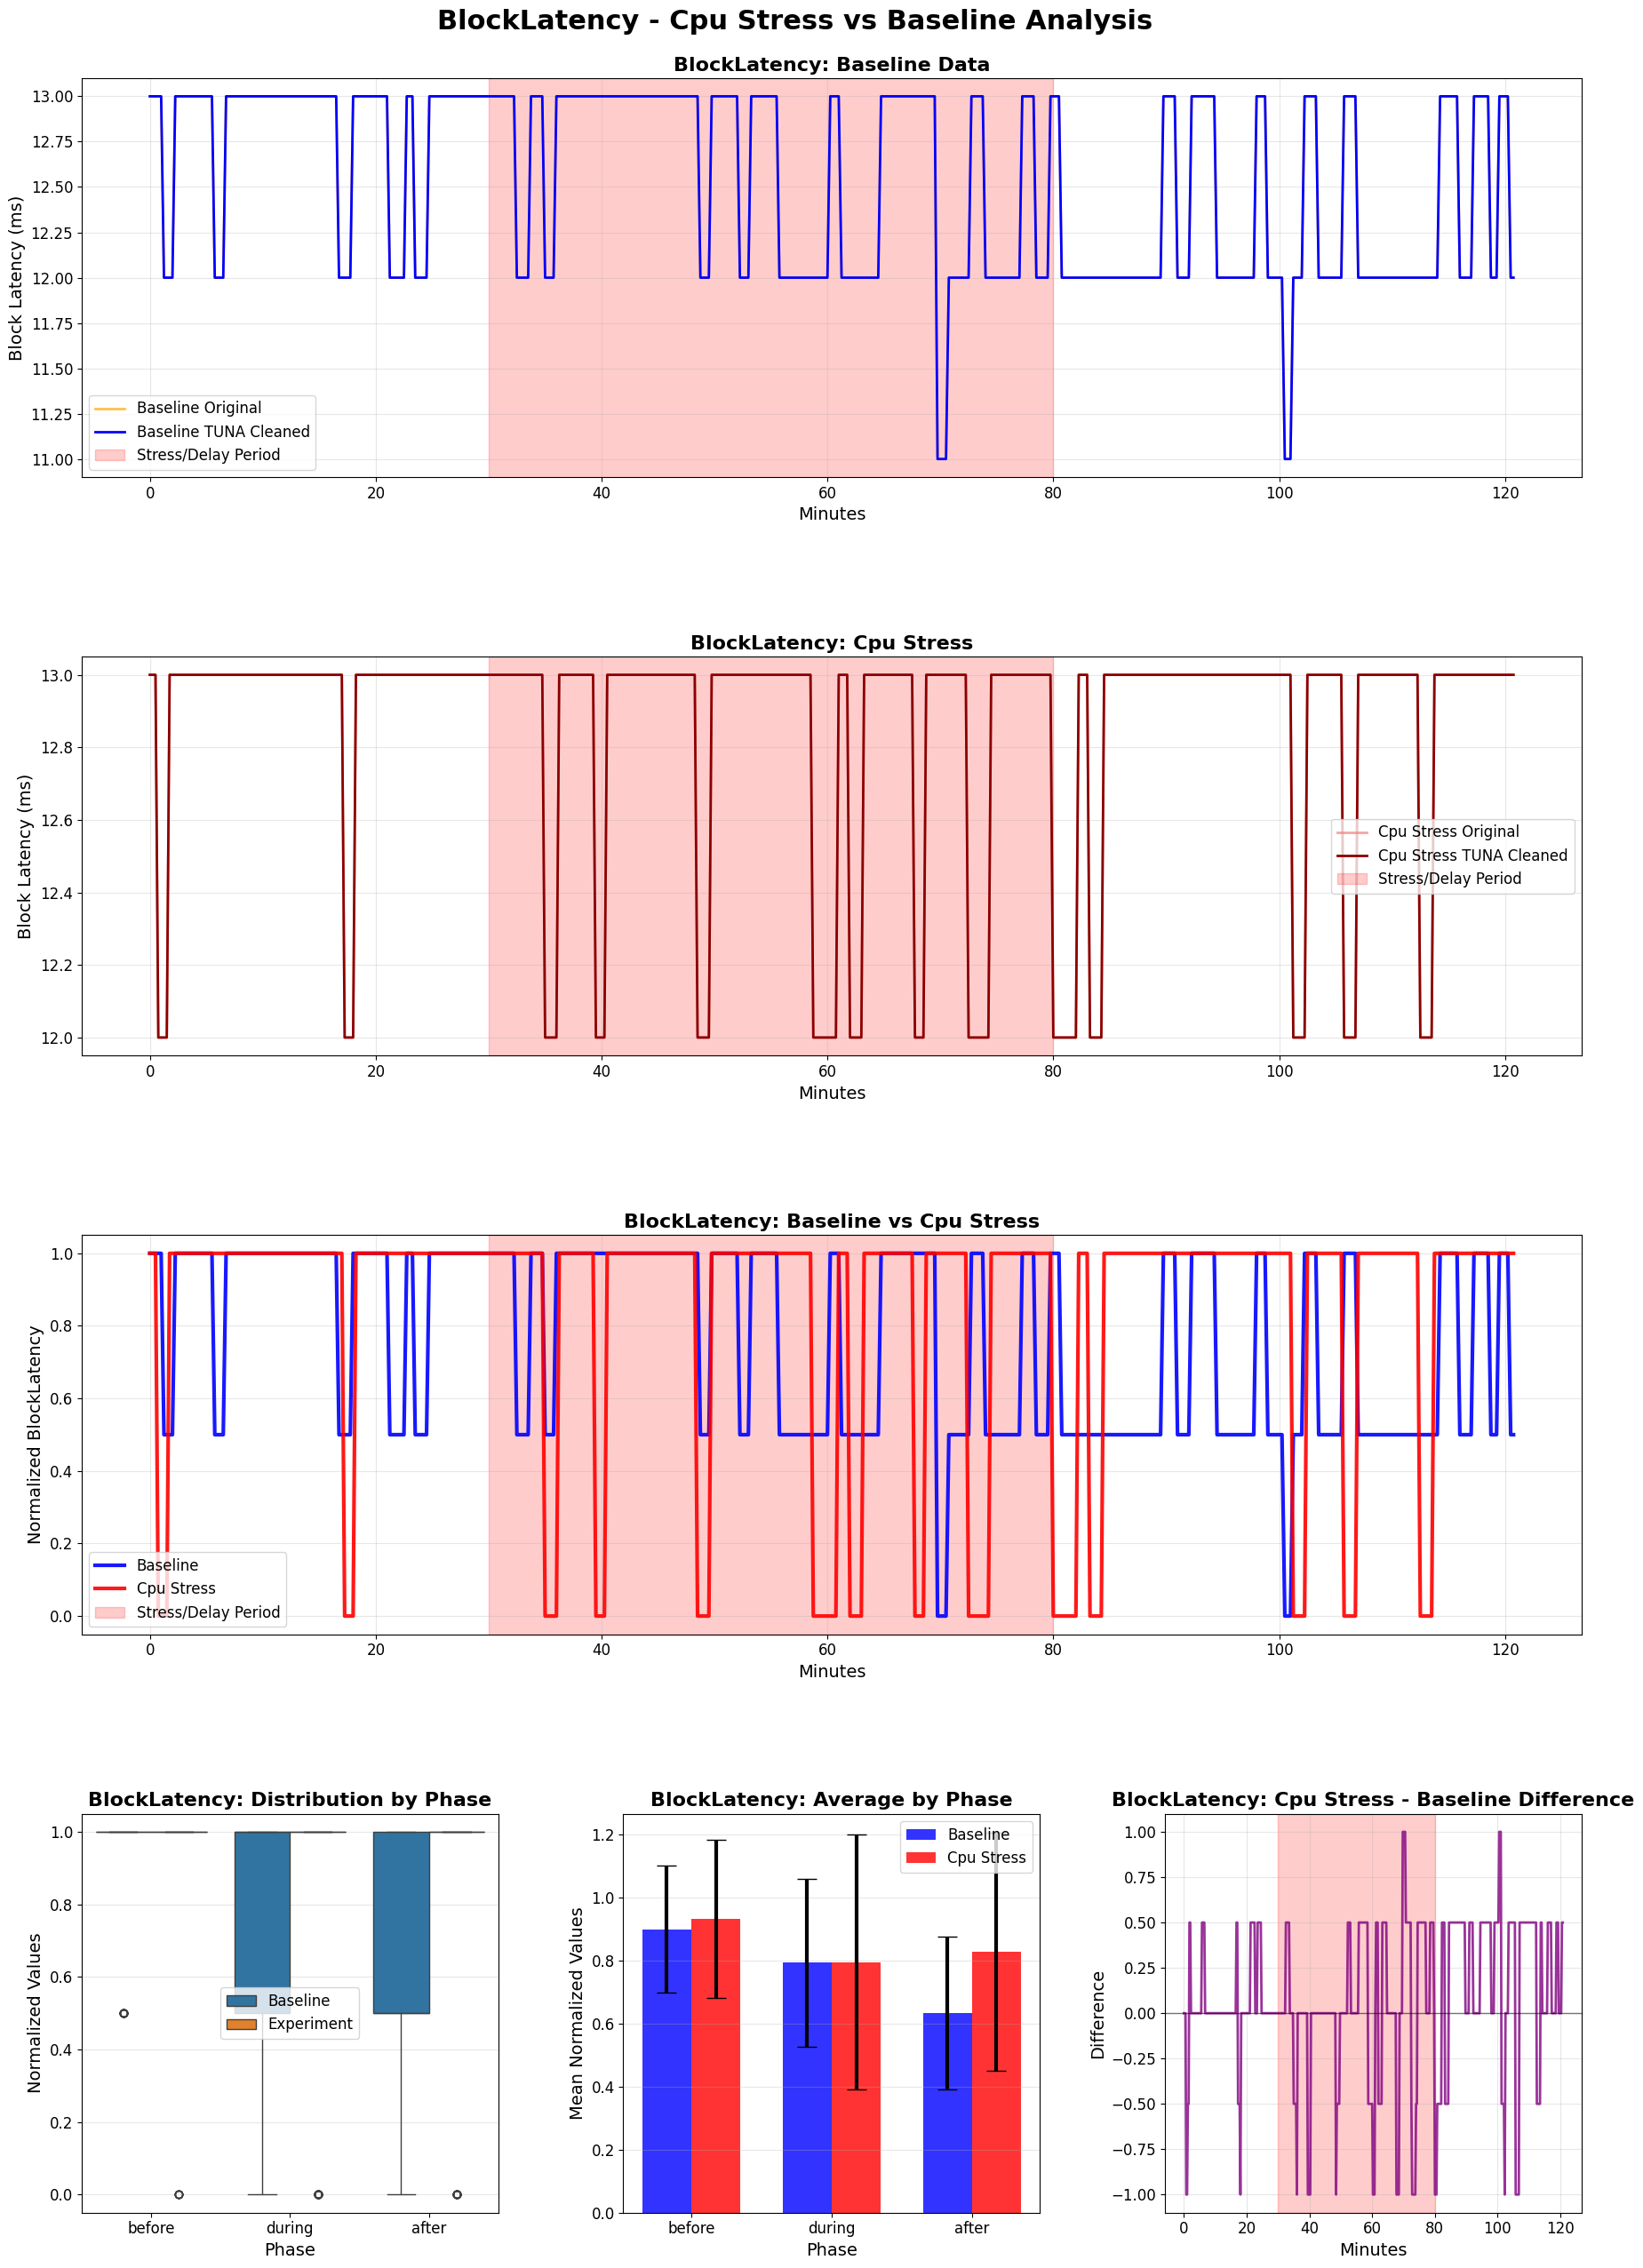


BLOCKLATENCY - CPU STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  CPU STRESS: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6350  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

CPU STRESS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.8282  0.3784  0.0  1.0
before  0.9333  0.2505  0.0  1.0
during  0.7960  0.4040  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -1.14, p=  0.2566 (NOT SIGNIFICANT)
  DURING  : t= -0.07, p=  0.9419 (NOT SIGNIFICANT)
  AFTER   : t= -5.49, p=  0.0000 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :   +3.70% (INCREASE)
  DURING  :   +0.31% (INCREASE)
  AFTER   :  +30.43% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (

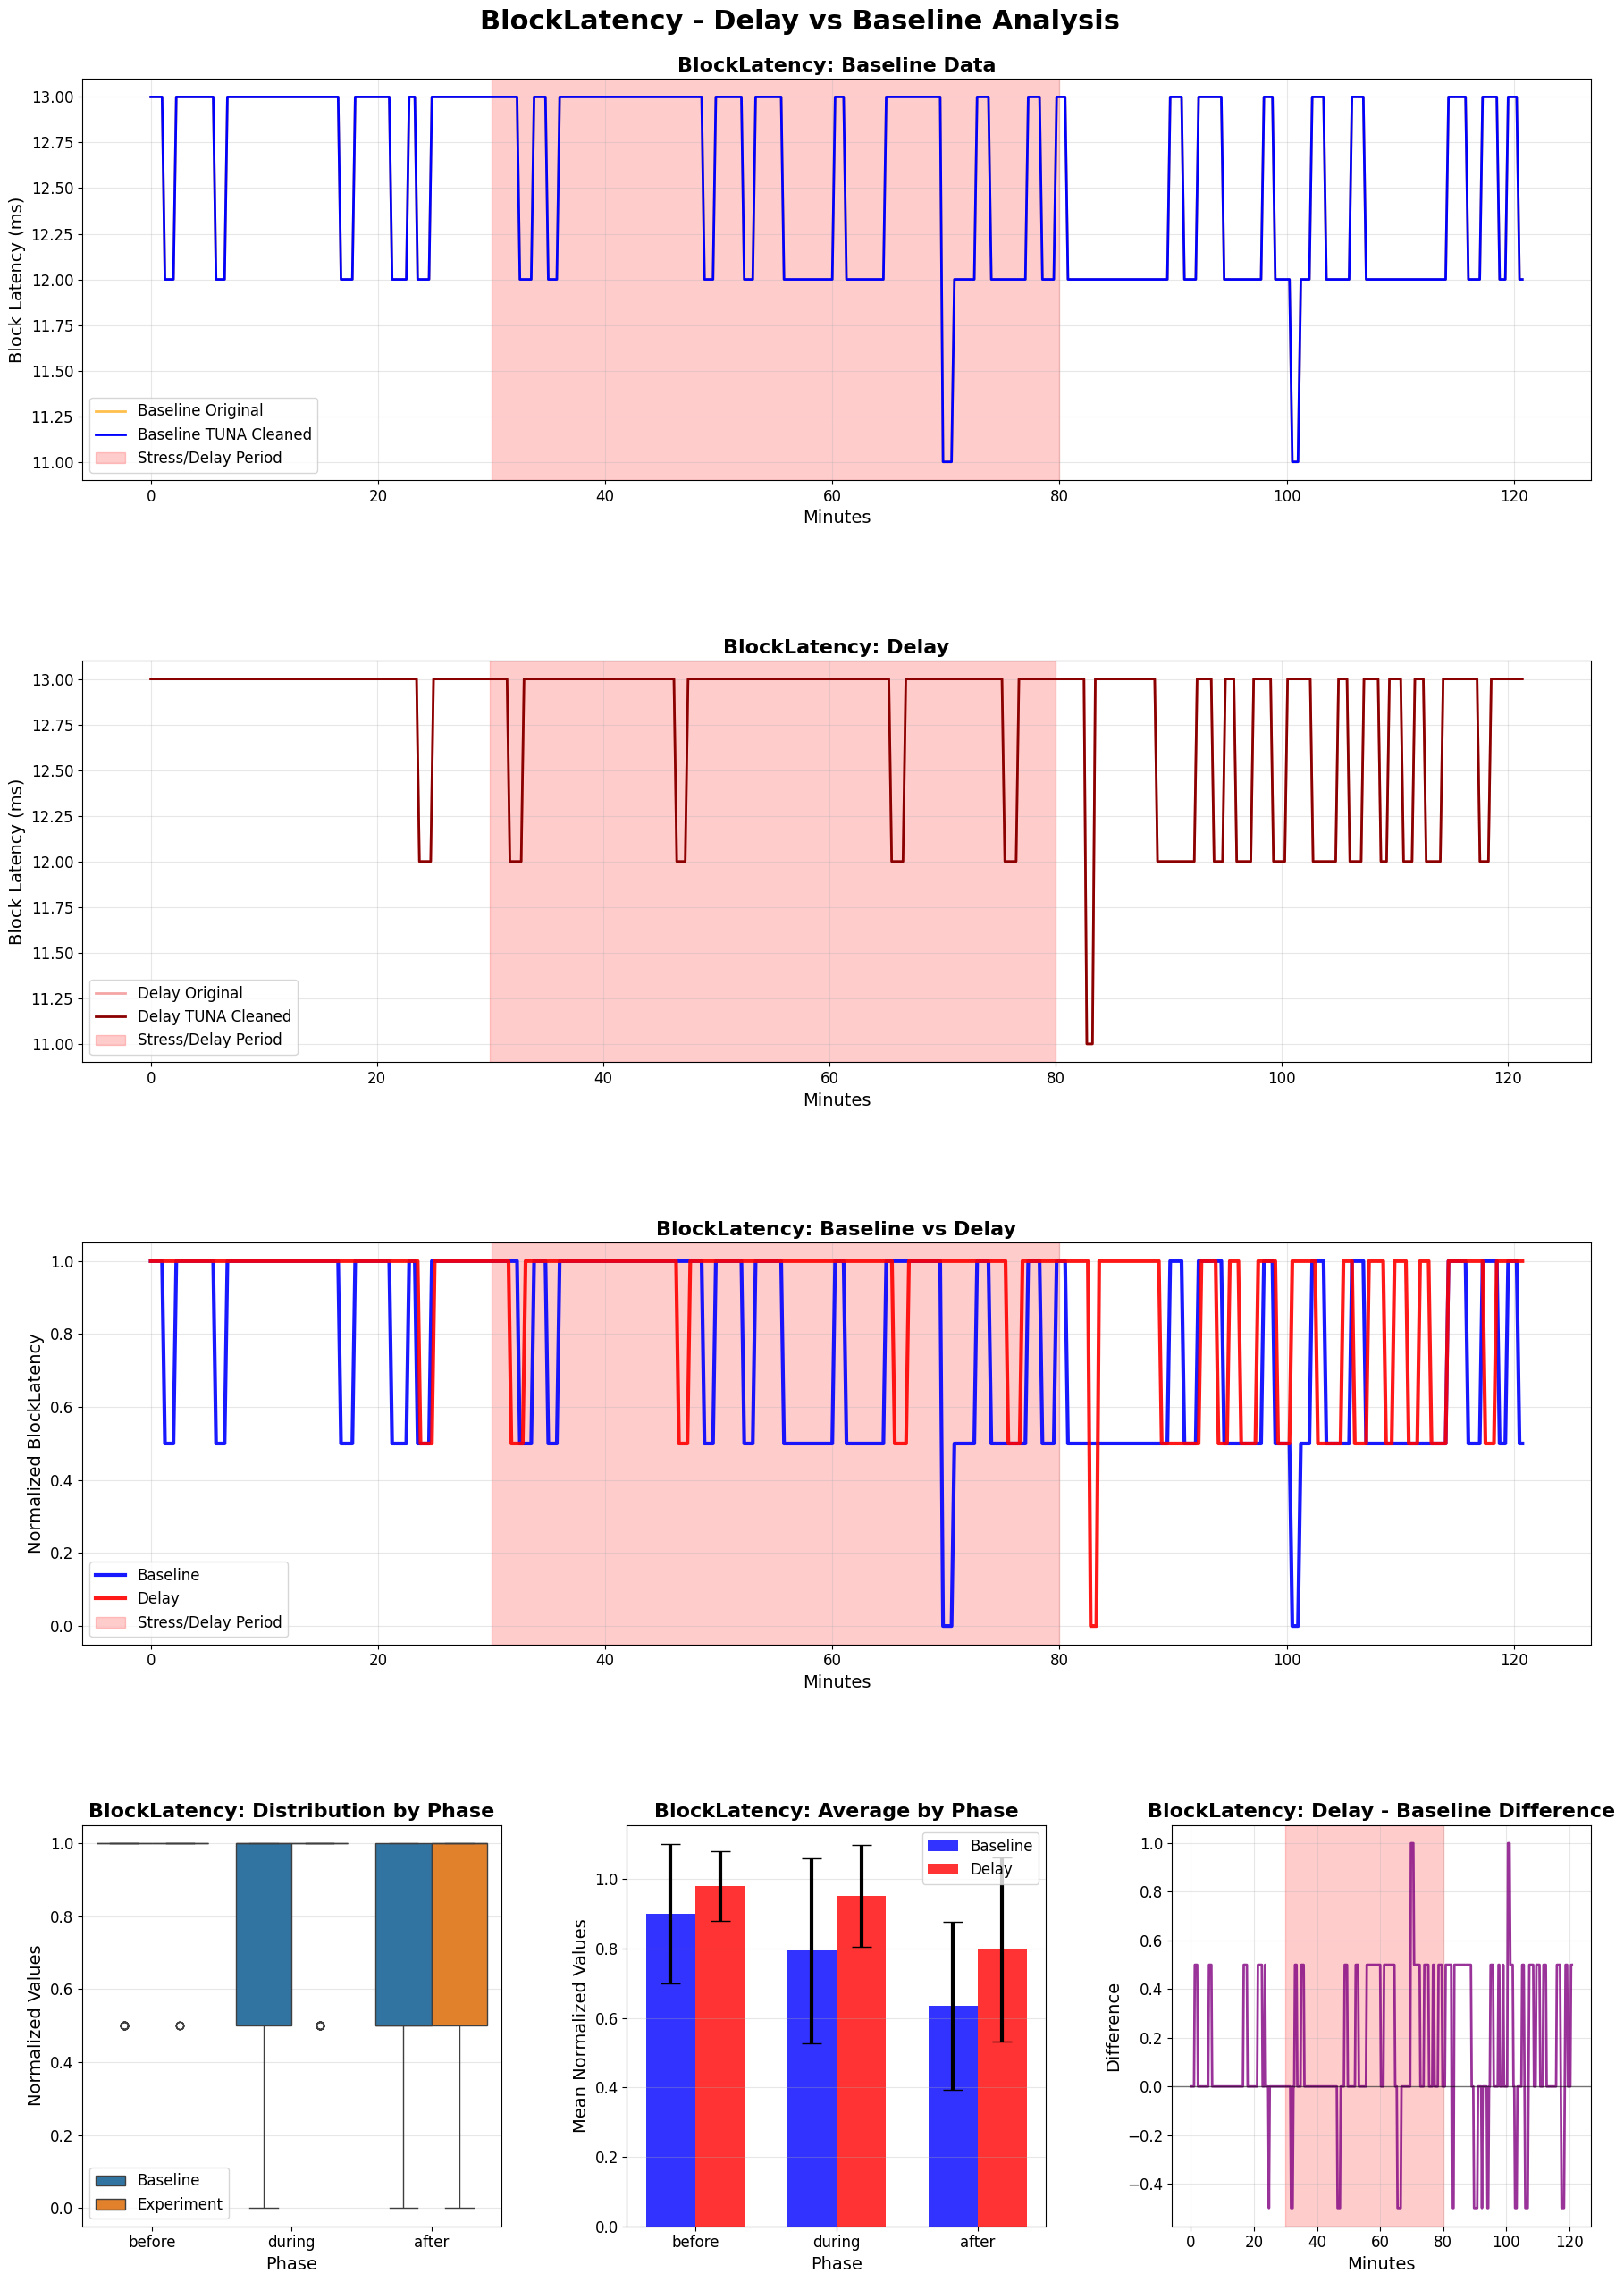


BLOCKLATENCY - DELAY VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  DELAY: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6350  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

DELAY STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.7975  0.2643  0.0  1.0
before  0.9792  0.1003  0.5  1.0
during  0.9527  0.1466  0.5  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -3.86, p=  0.0001 (SIGNIFICANT)
  DURING  : t= -7.42, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -5.79, p=  0.0000 (SIGNIFICANT)

DELAY IMPACT:
  BEFORE  :   +8.80% (INCREASE)
  DURING  :  +20.06% (INCREASE)
  AFTER   :  +25.60% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)
  Columns analyzed: ['di

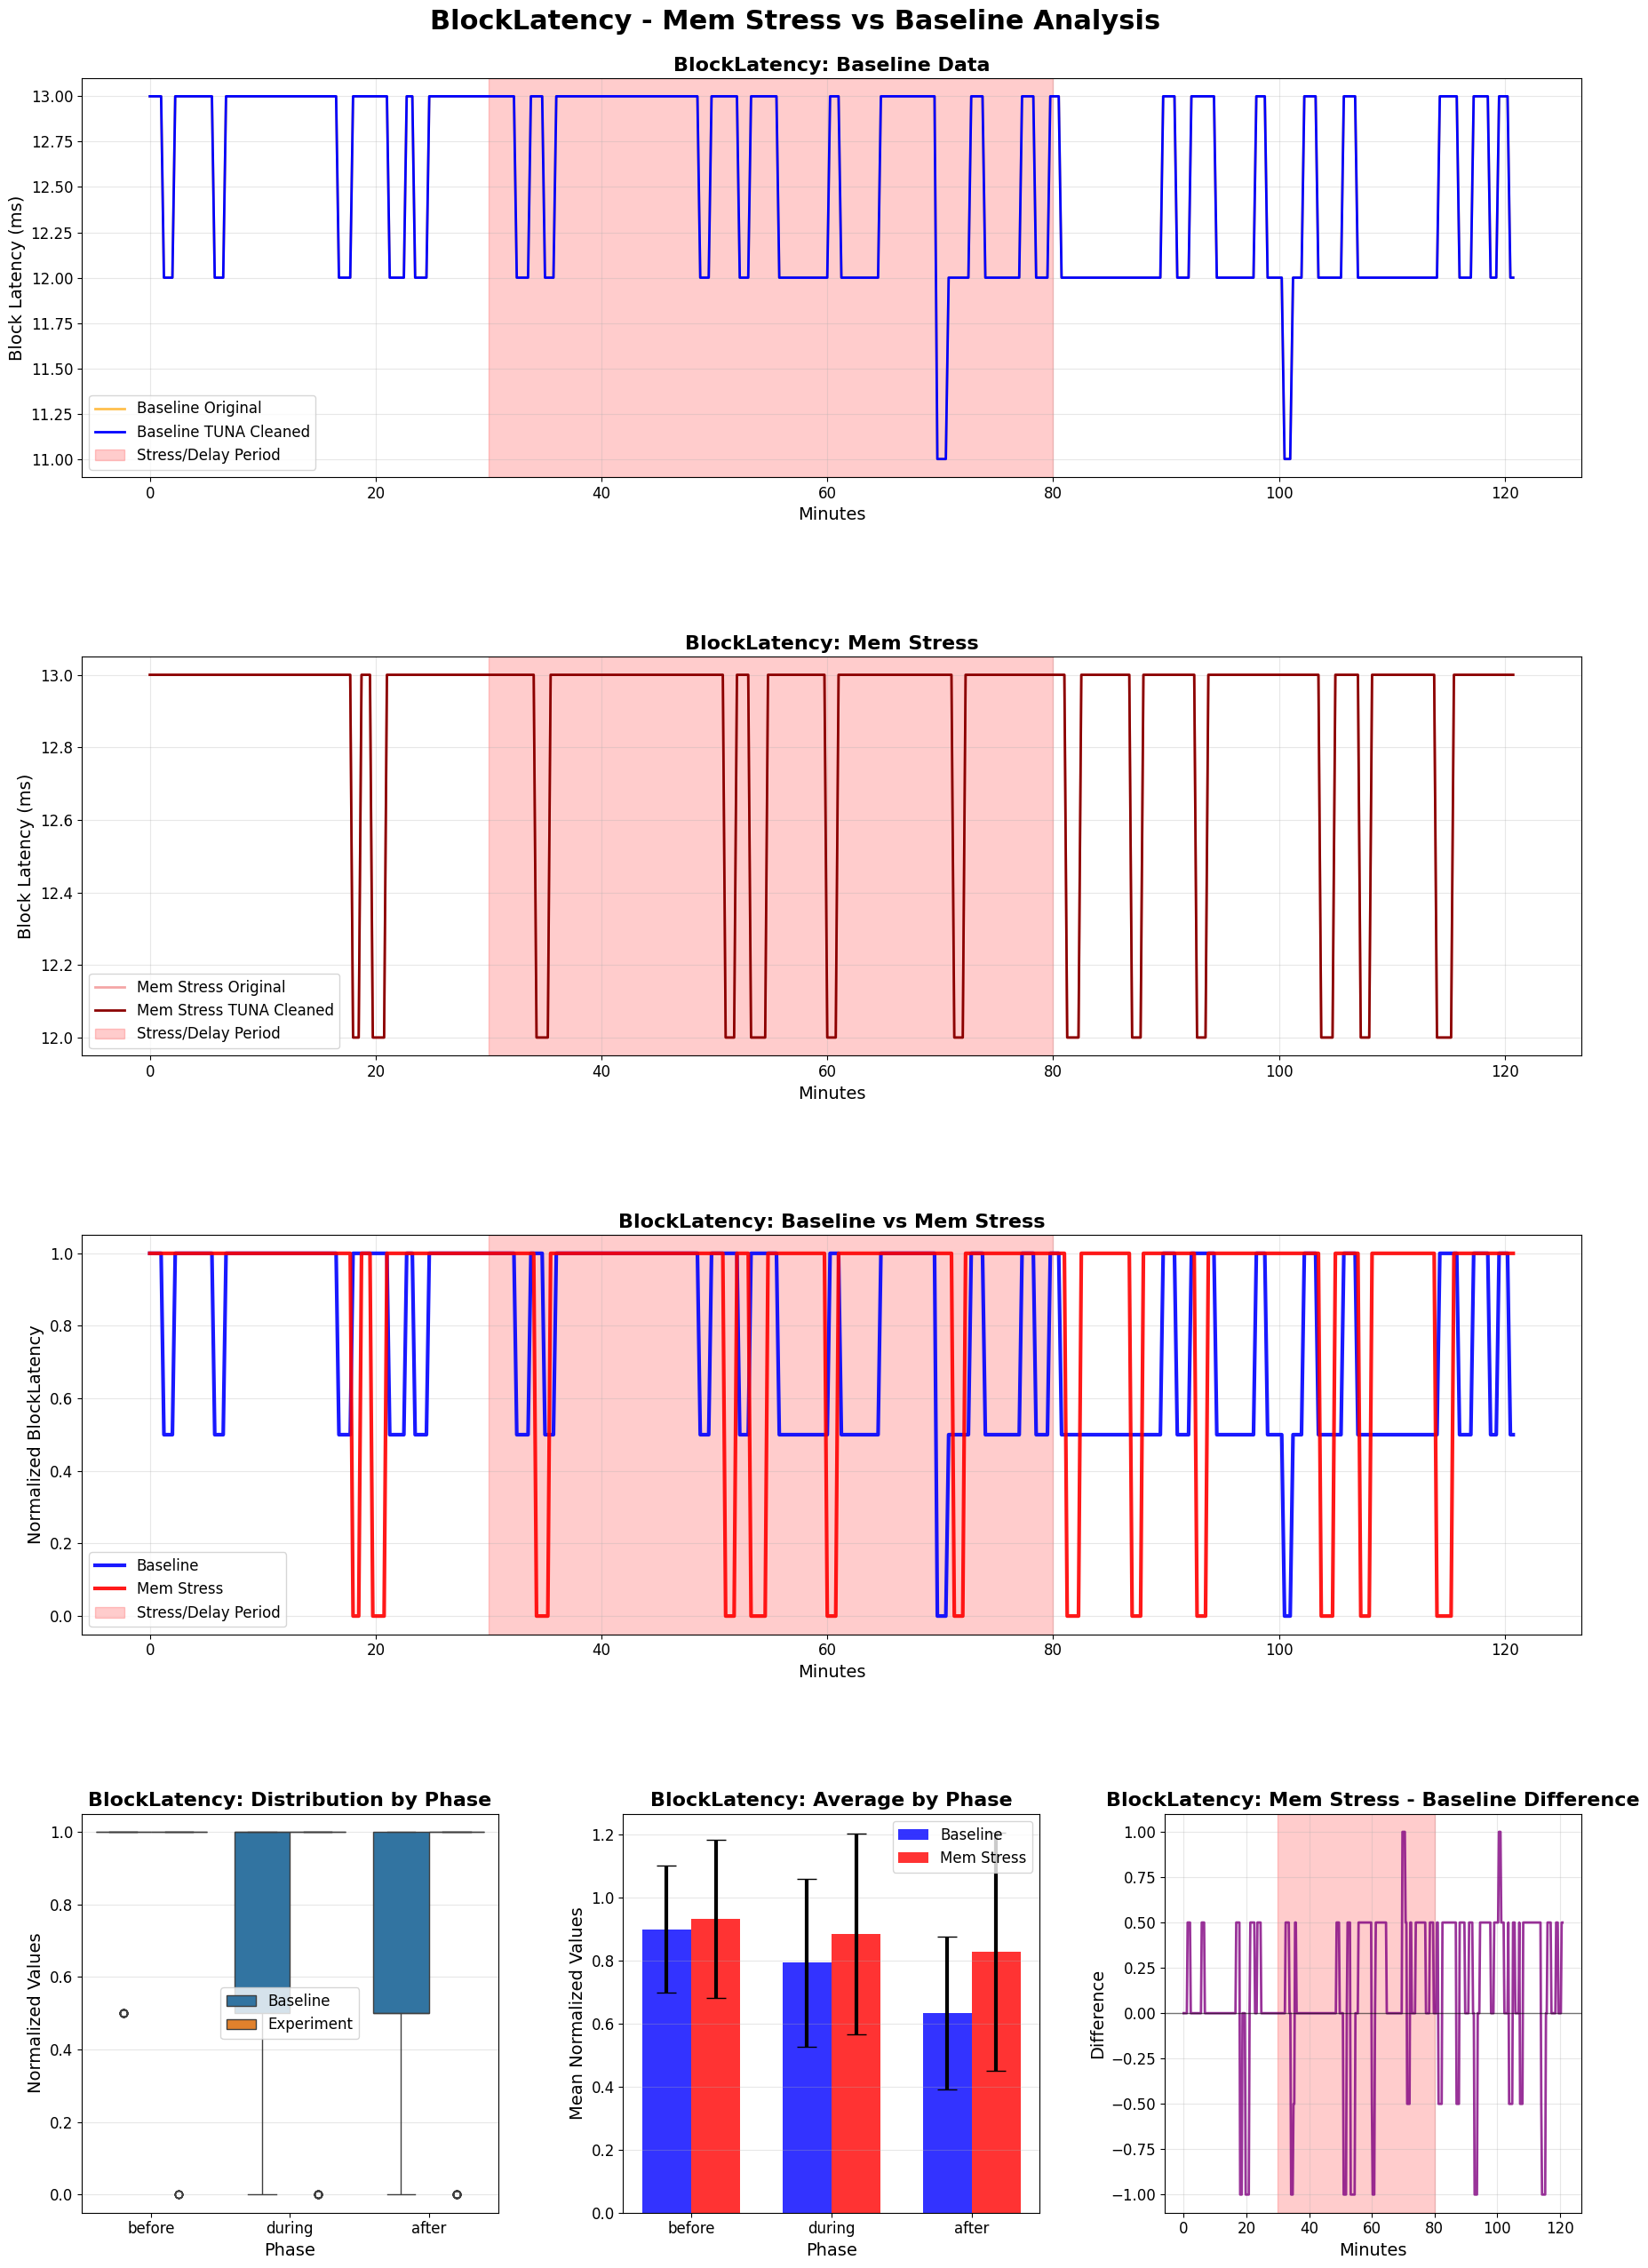


BLOCKLATENCY - MEM STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  MEM STRESS: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6350  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

MEM STRESS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.8282  0.3784  0.0  1.0
before  0.9333  0.2505  0.0  1.0
during  0.8856  0.3191  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -1.14, p=  0.2566 (NOT SIGNIFICANT)
  DURING  : t= -3.14, p=  0.0018 (SIGNIFICANT)
  AFTER   : t= -5.49, p=  0.0000 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :   +3.70% (INCREASE)
  DURING  :  +11.60% (INCREASE)
  AFTER   :  +30.43% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)


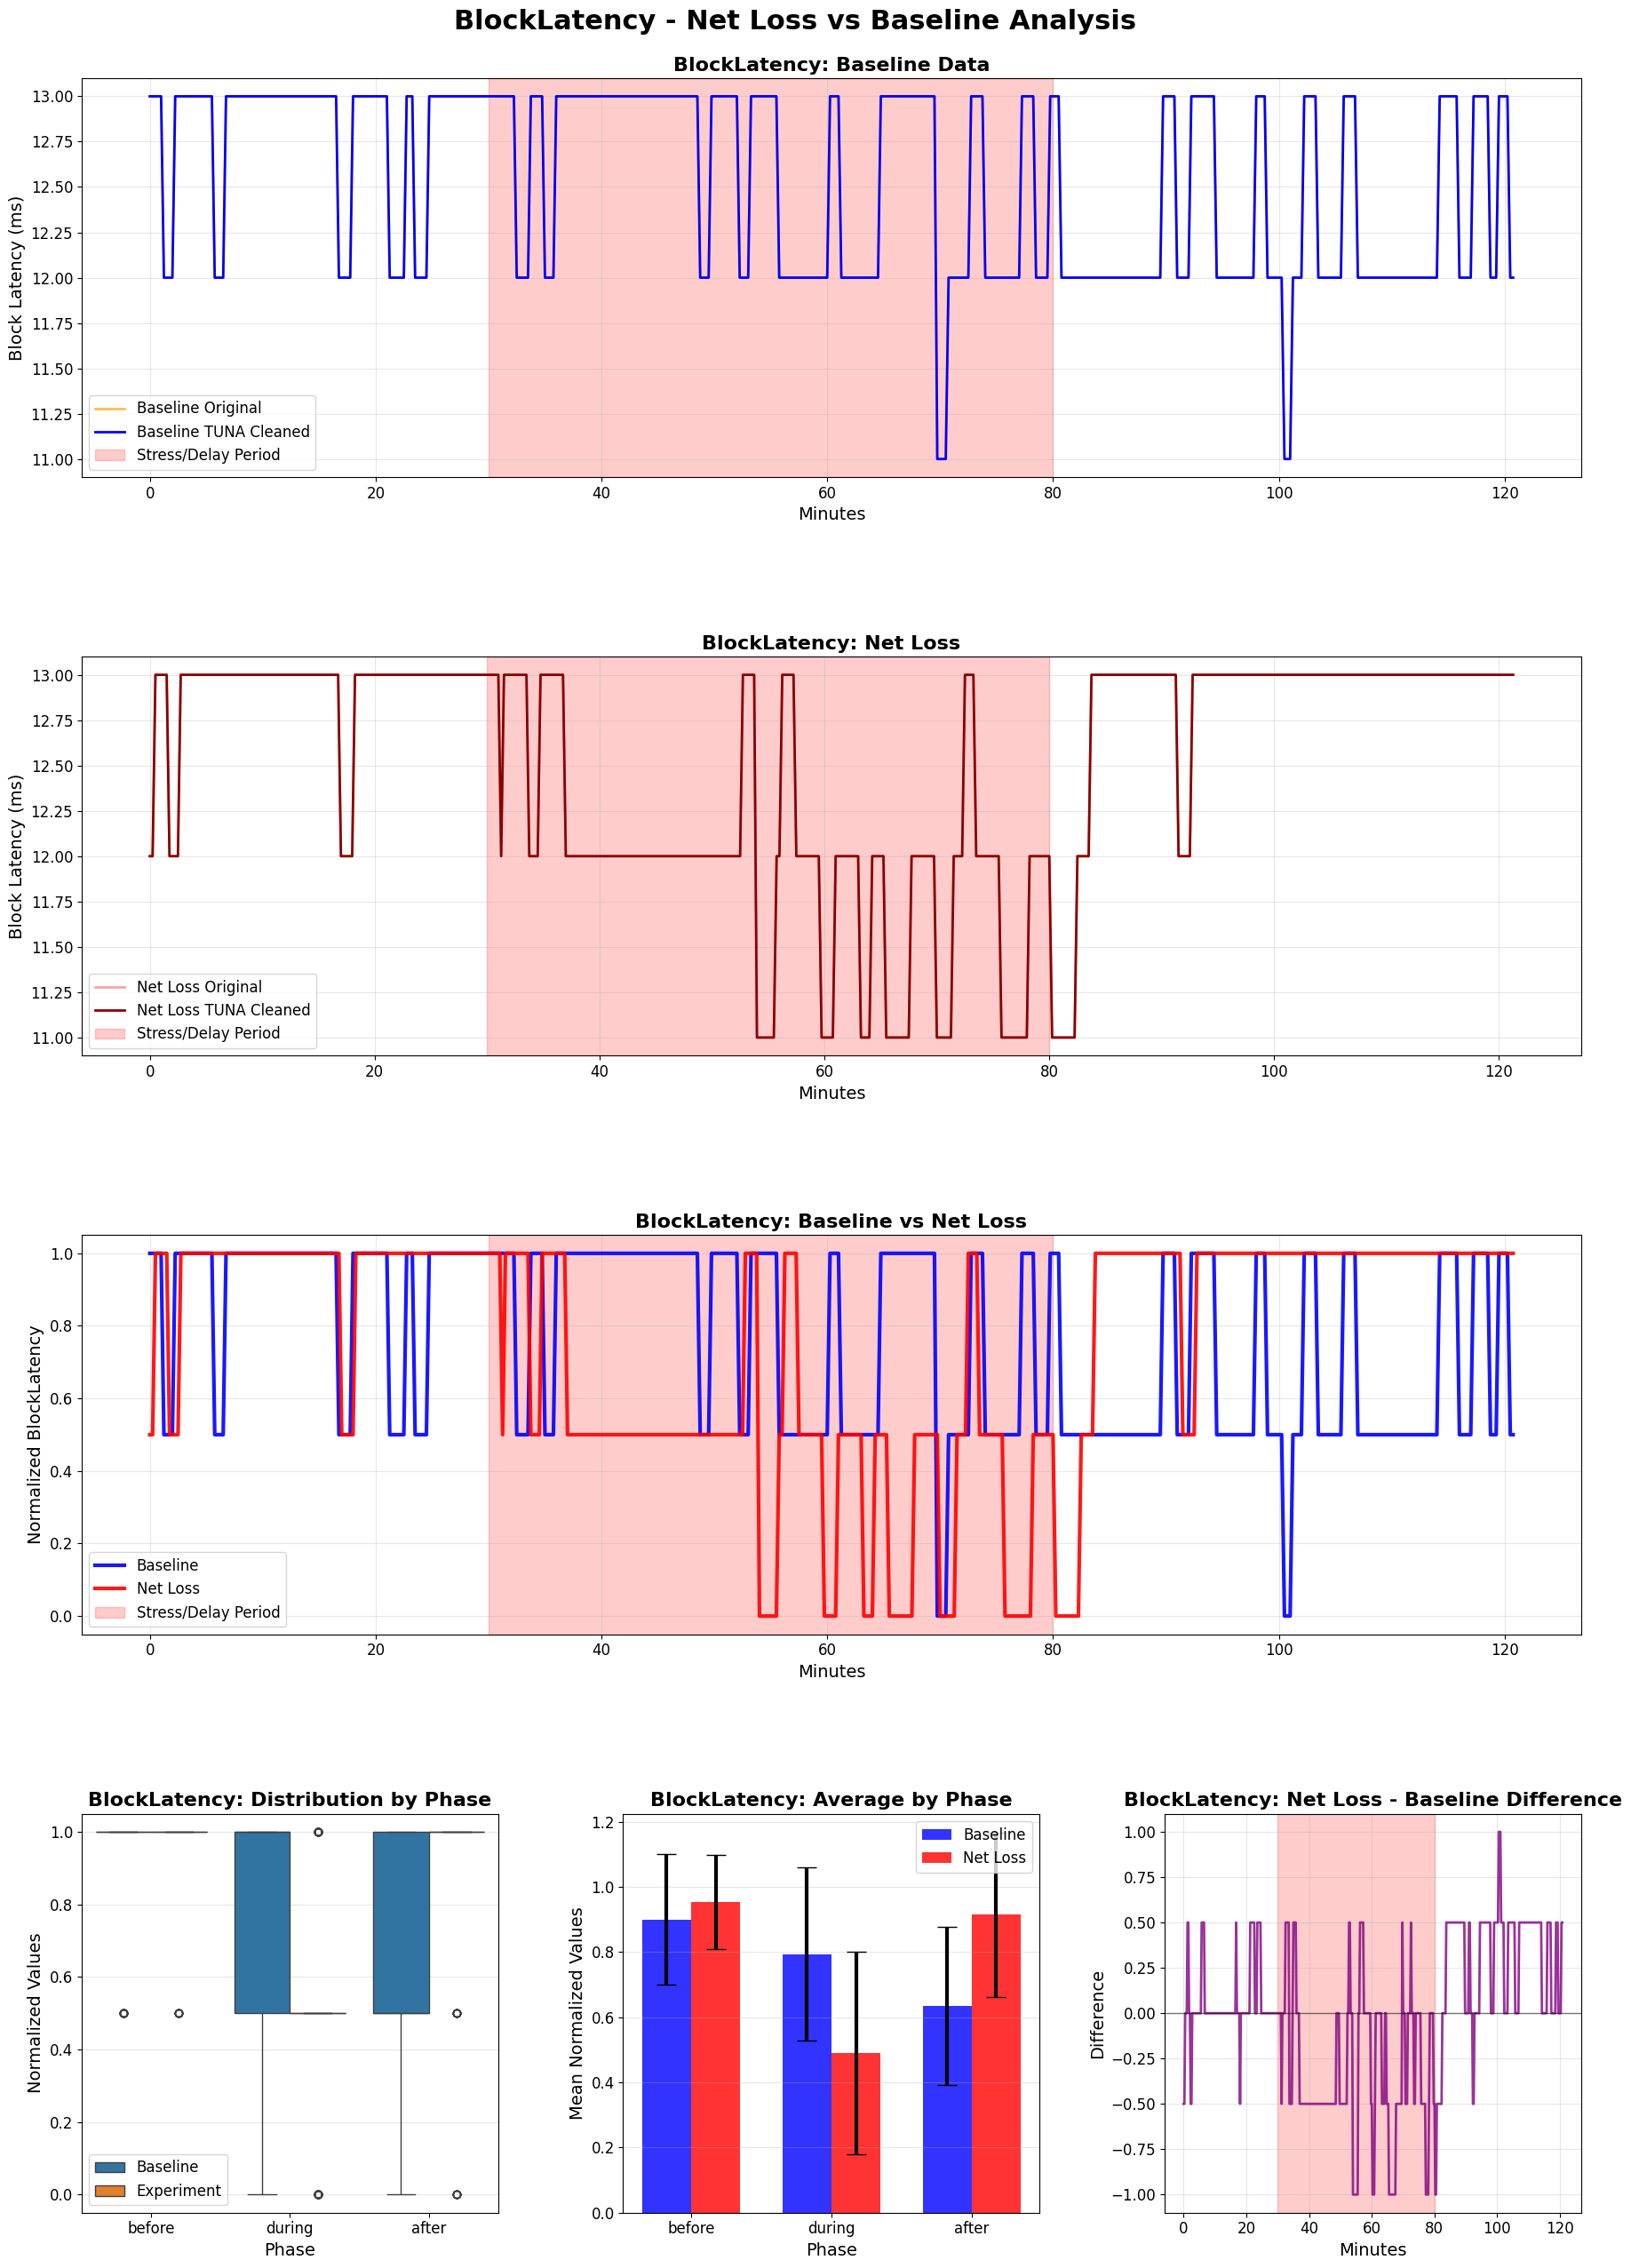


BLOCKLATENCY - NET LOSS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  NET LOSS: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.6350  0.2426  0.0  1.0
before  0.9000  0.2008  0.5  1.0
during  0.7935  0.2663  0.0  1.0

NET LOSS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.9141  0.2521  0.0  1.0
before  0.9542  0.1449  0.5  1.0
during  0.4900  0.3121  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.40, p=  0.0173 (SIGNIFICANT)
  DURING  : t= 10.49, p=  0.0000 (SIGNIFICANT)
  AFTER   : t=-10.19, p=  0.0000 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :   +6.02% (INCREASE)
  DURING  :  -38.24% (DECREASE)
  AFTER   :  +43.96% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: BlockLatency
  Metric type: Block Latency (ms)
  Columns an

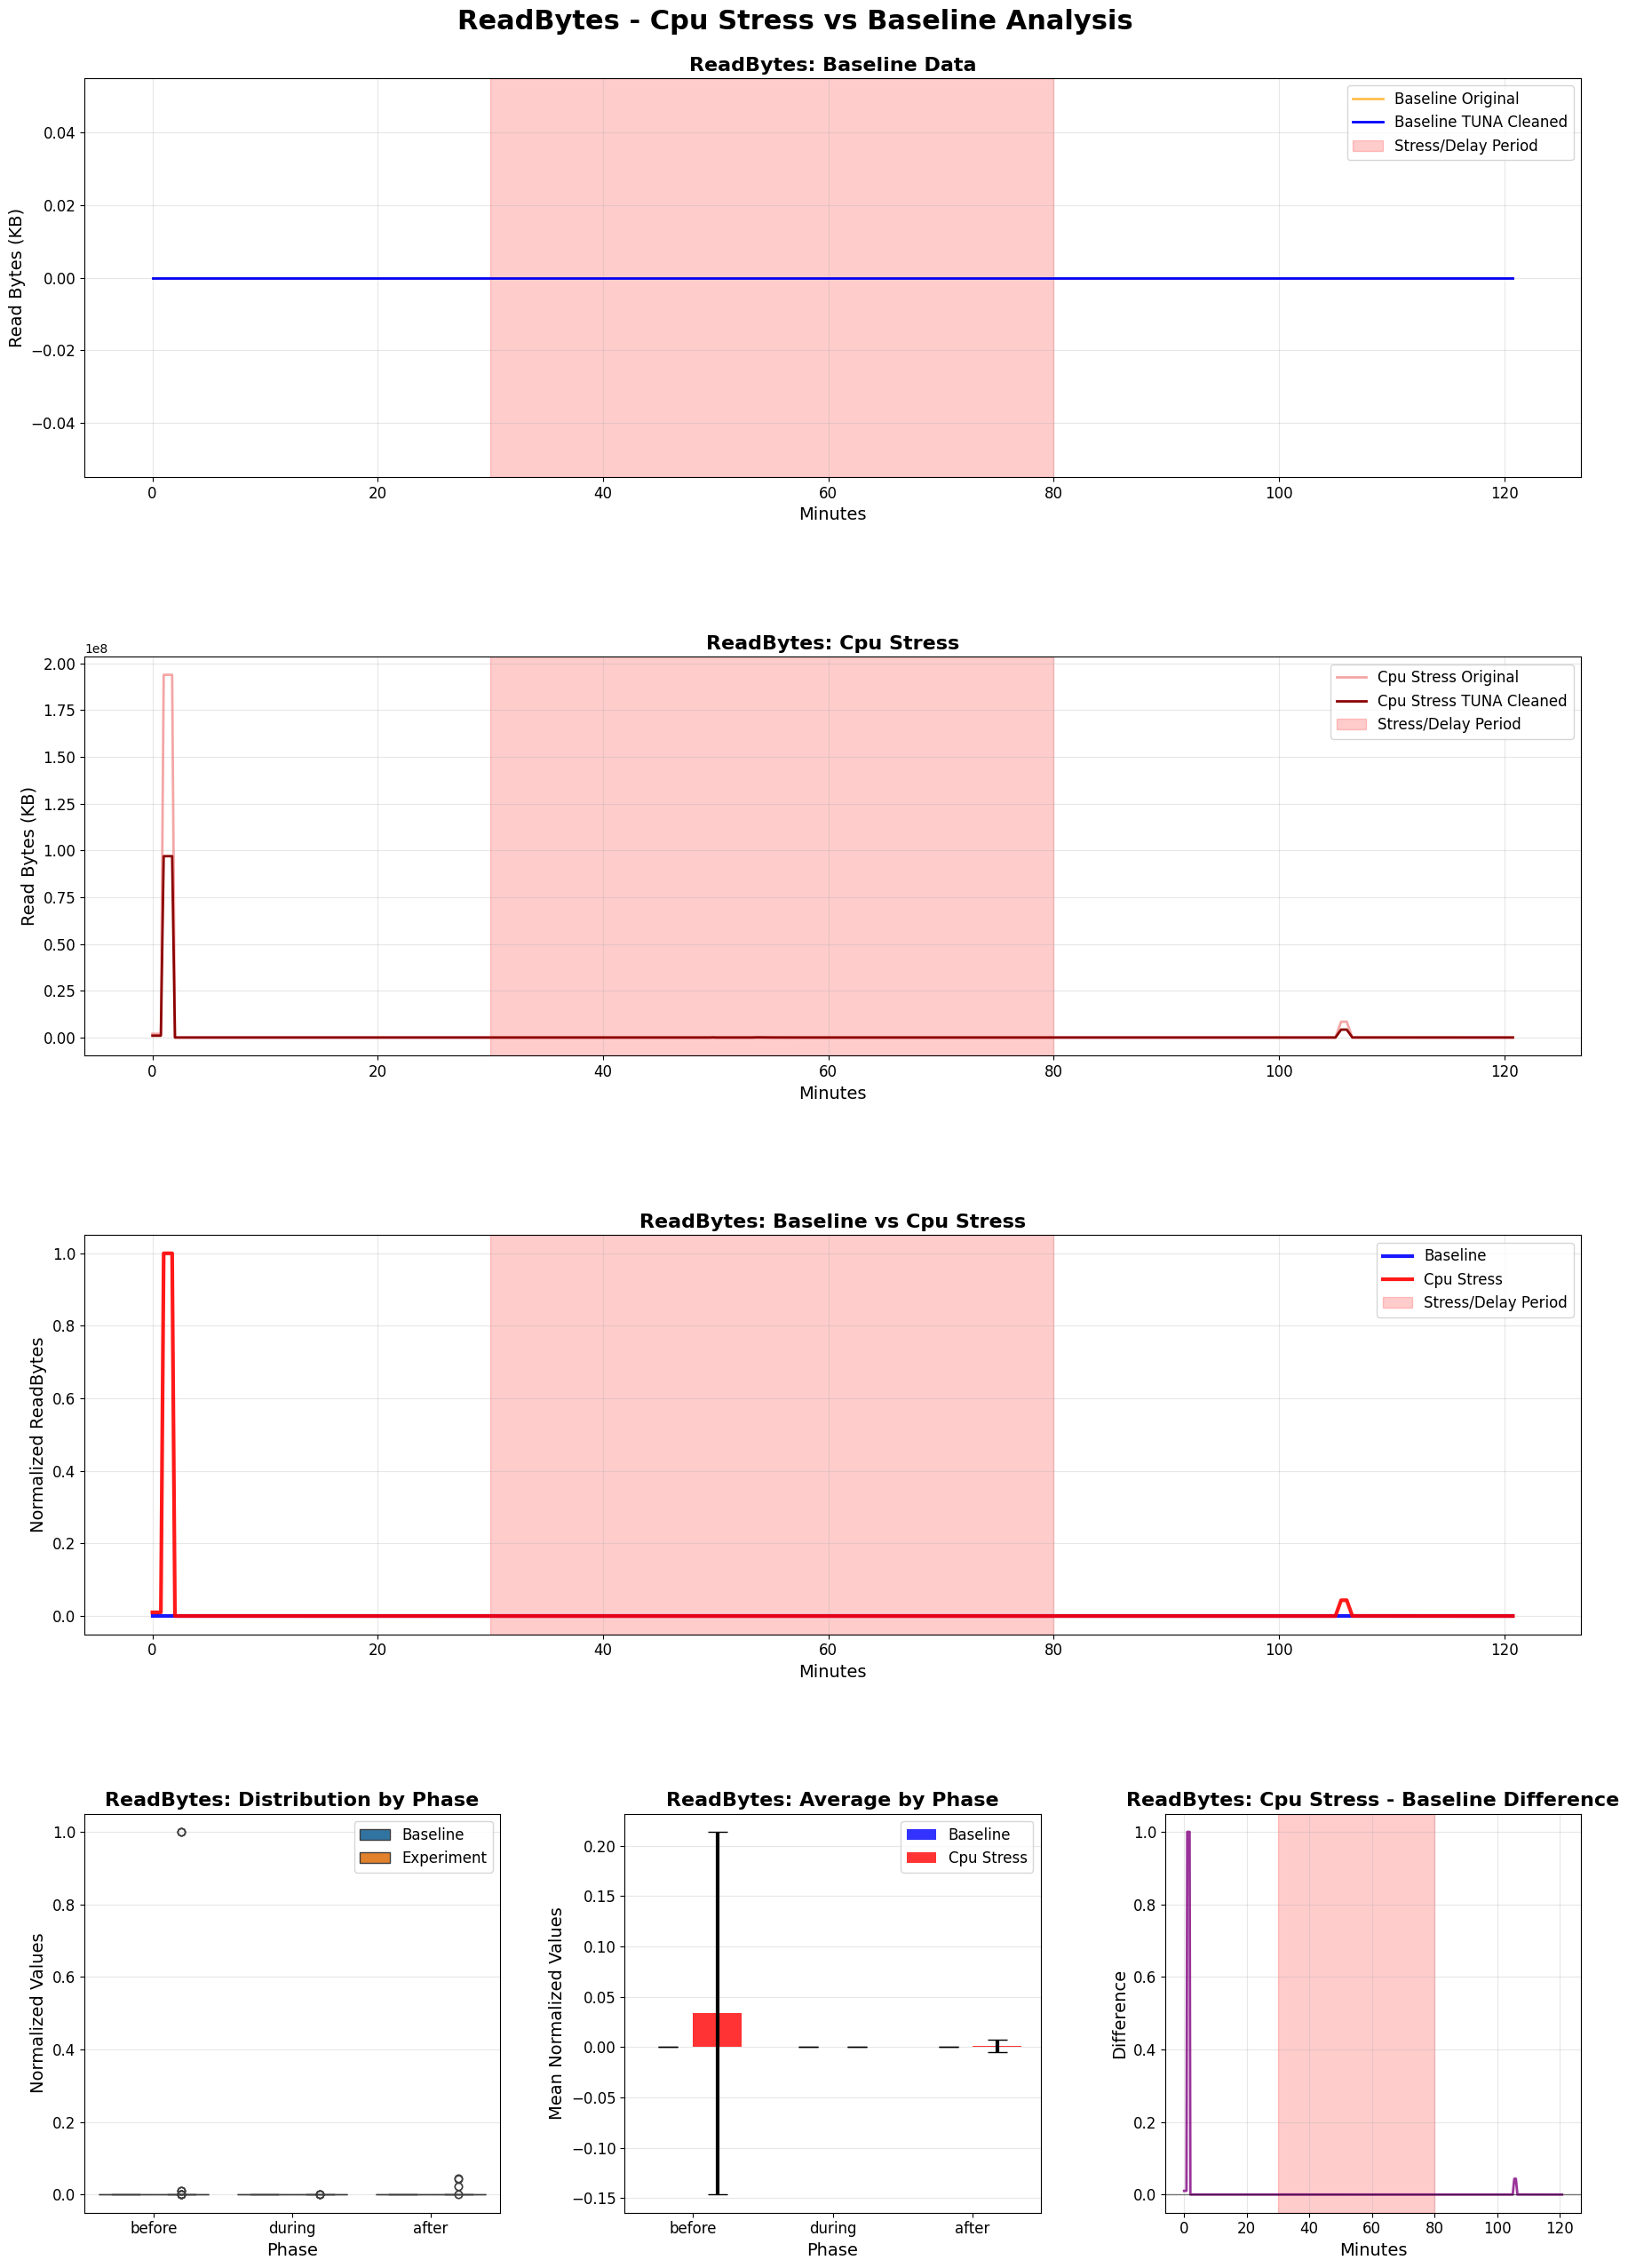


READBYTES - CPU STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  CPU STRESS: 73 outliers removed
    Noise Reduction: 50.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

CPU STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0011  0.0063  0.0  0.0437
before  0.0337  0.1802  0.0  1.0000
during  0.0000  0.0001  0.0  0.0003

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.05, p=  0.0417 (SIGNIFICANT)
  DURING  : t= -2.69, p=  0.0075 (SIGNIFICANT)
  AFTER   : t= -2.17, p=  0.0309 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyzed

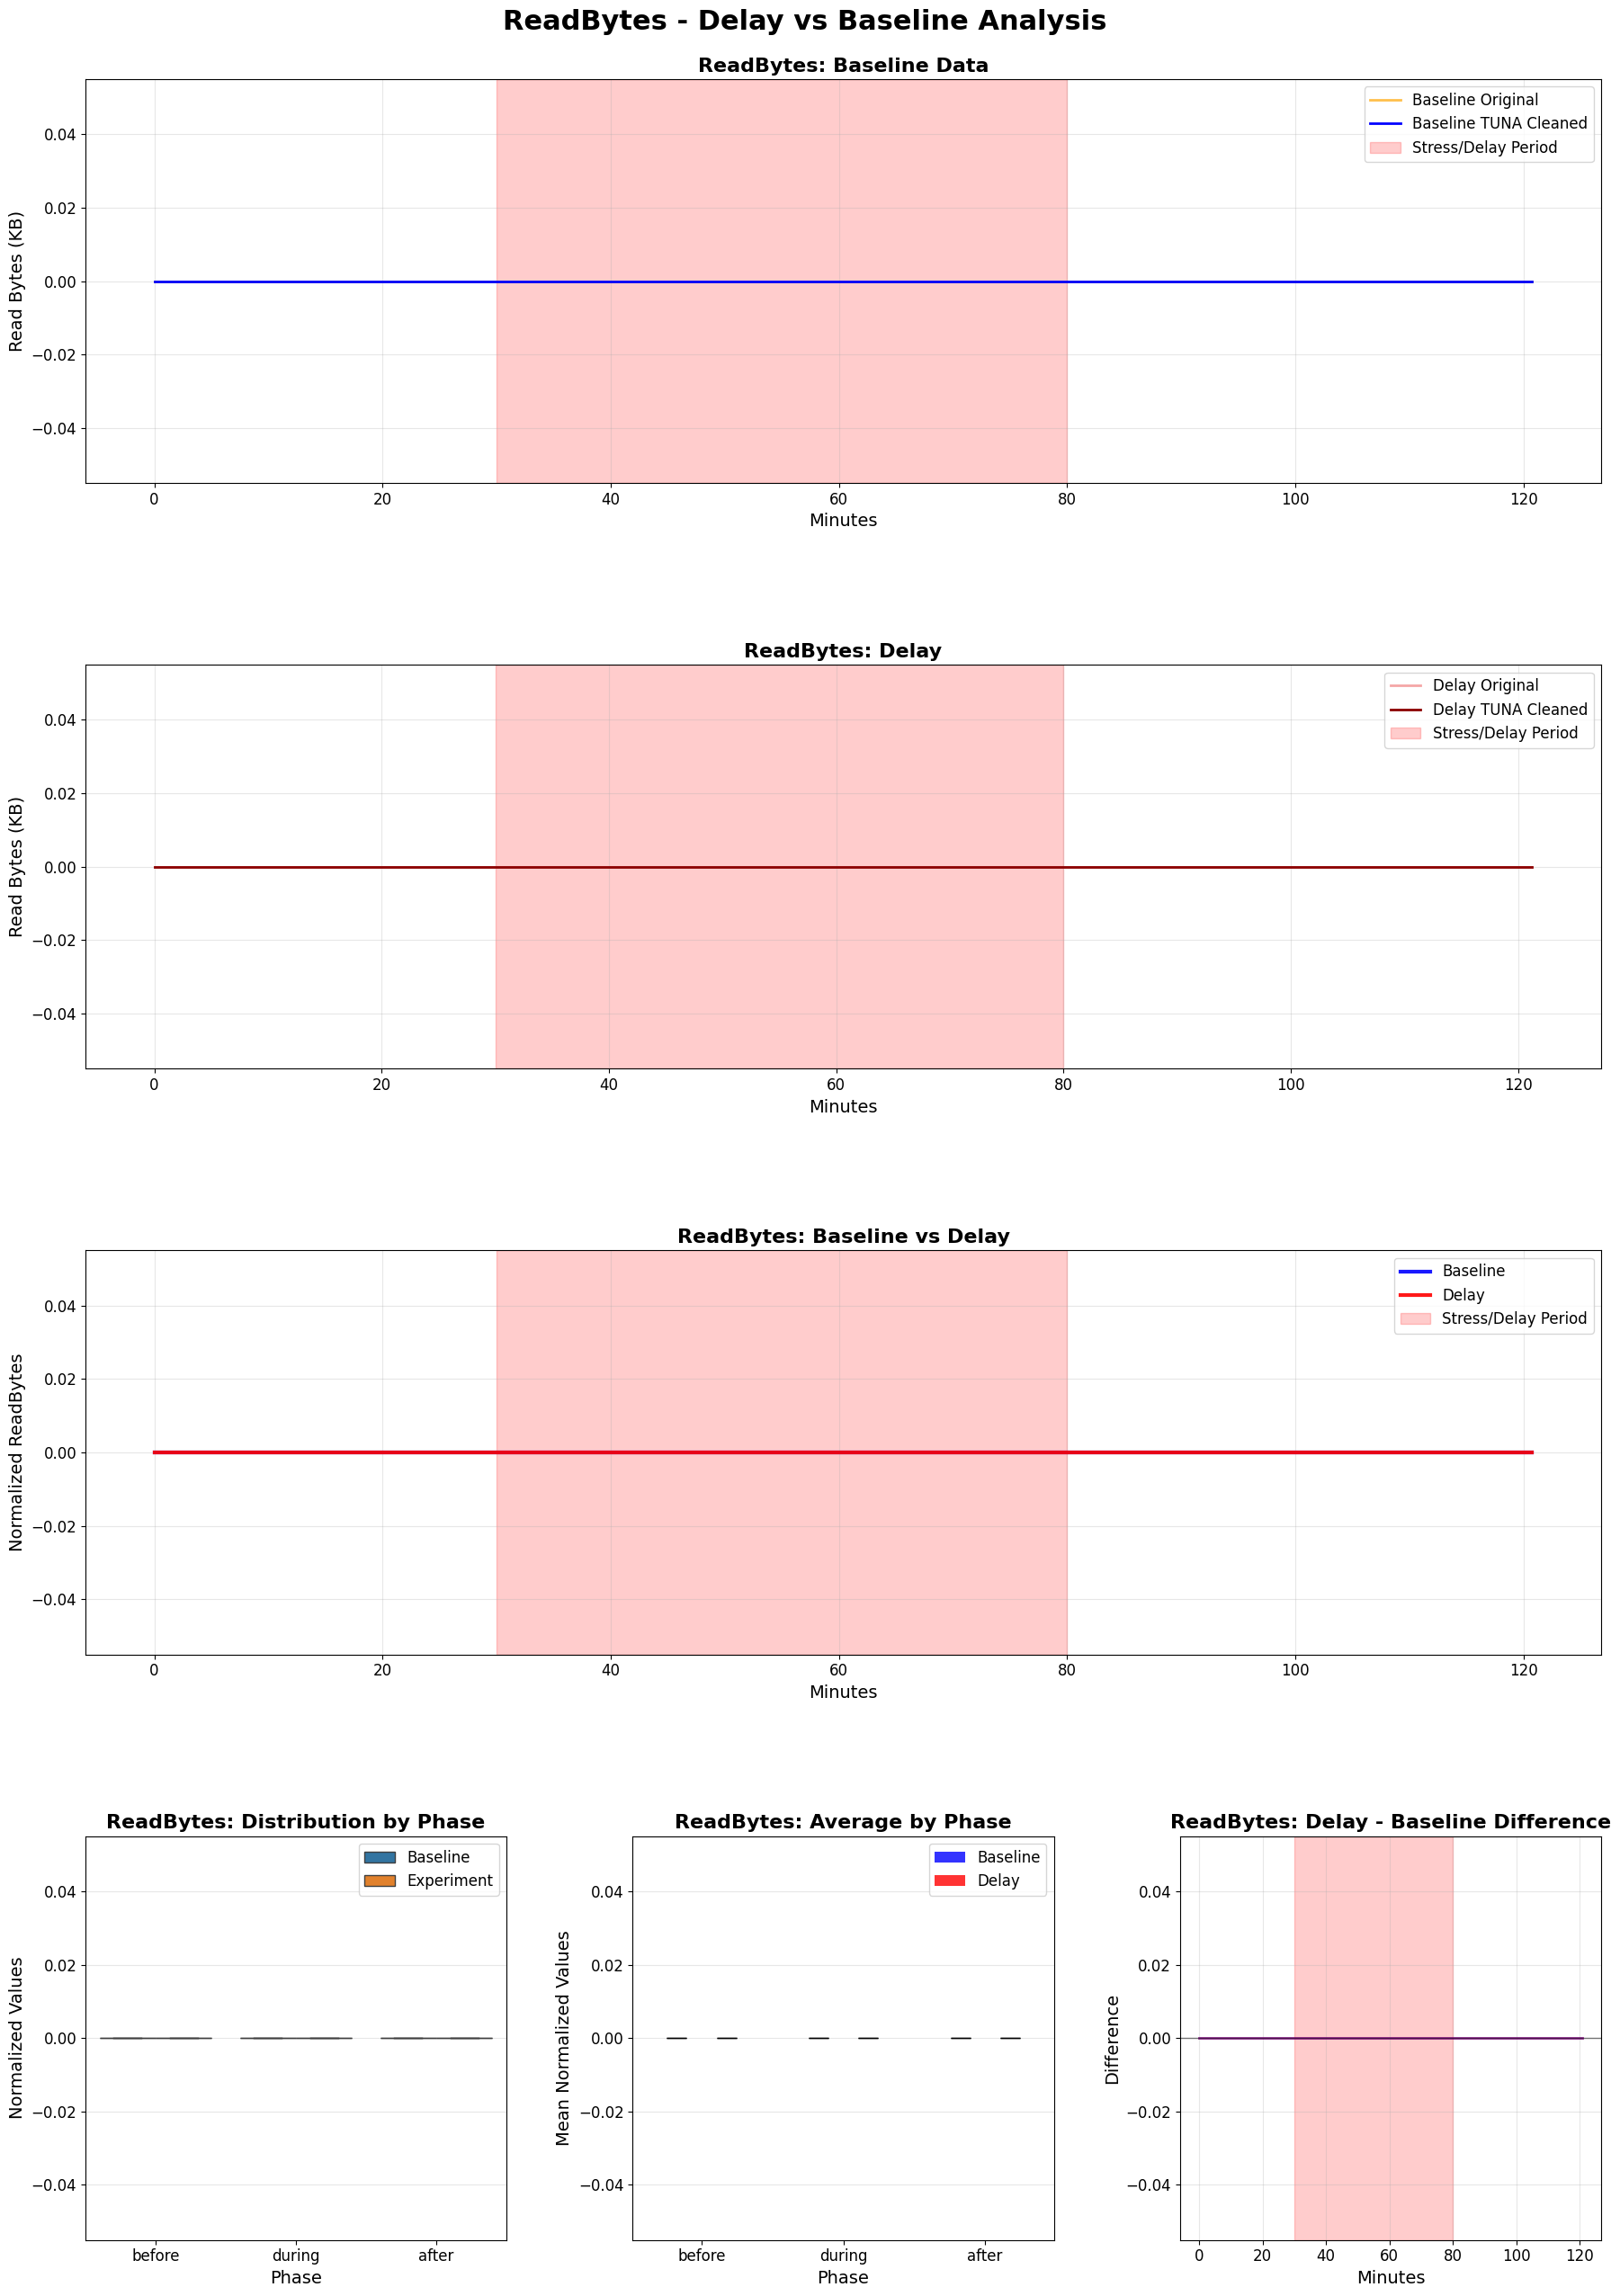


READBYTES - DELAY VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  DELAY: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

DELAY STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=   nan, p=     nan (NOT SIGNIFICANT)
  DURING  : t=   nan, p=     nan (NOT SIGNIFICANT)
  AFTER   : t=   nan, p=     nan (NOT SIGNIFICANT)

DELAY IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyzed: ['openeuler-home', 'openeuler-root', 'openeuler-

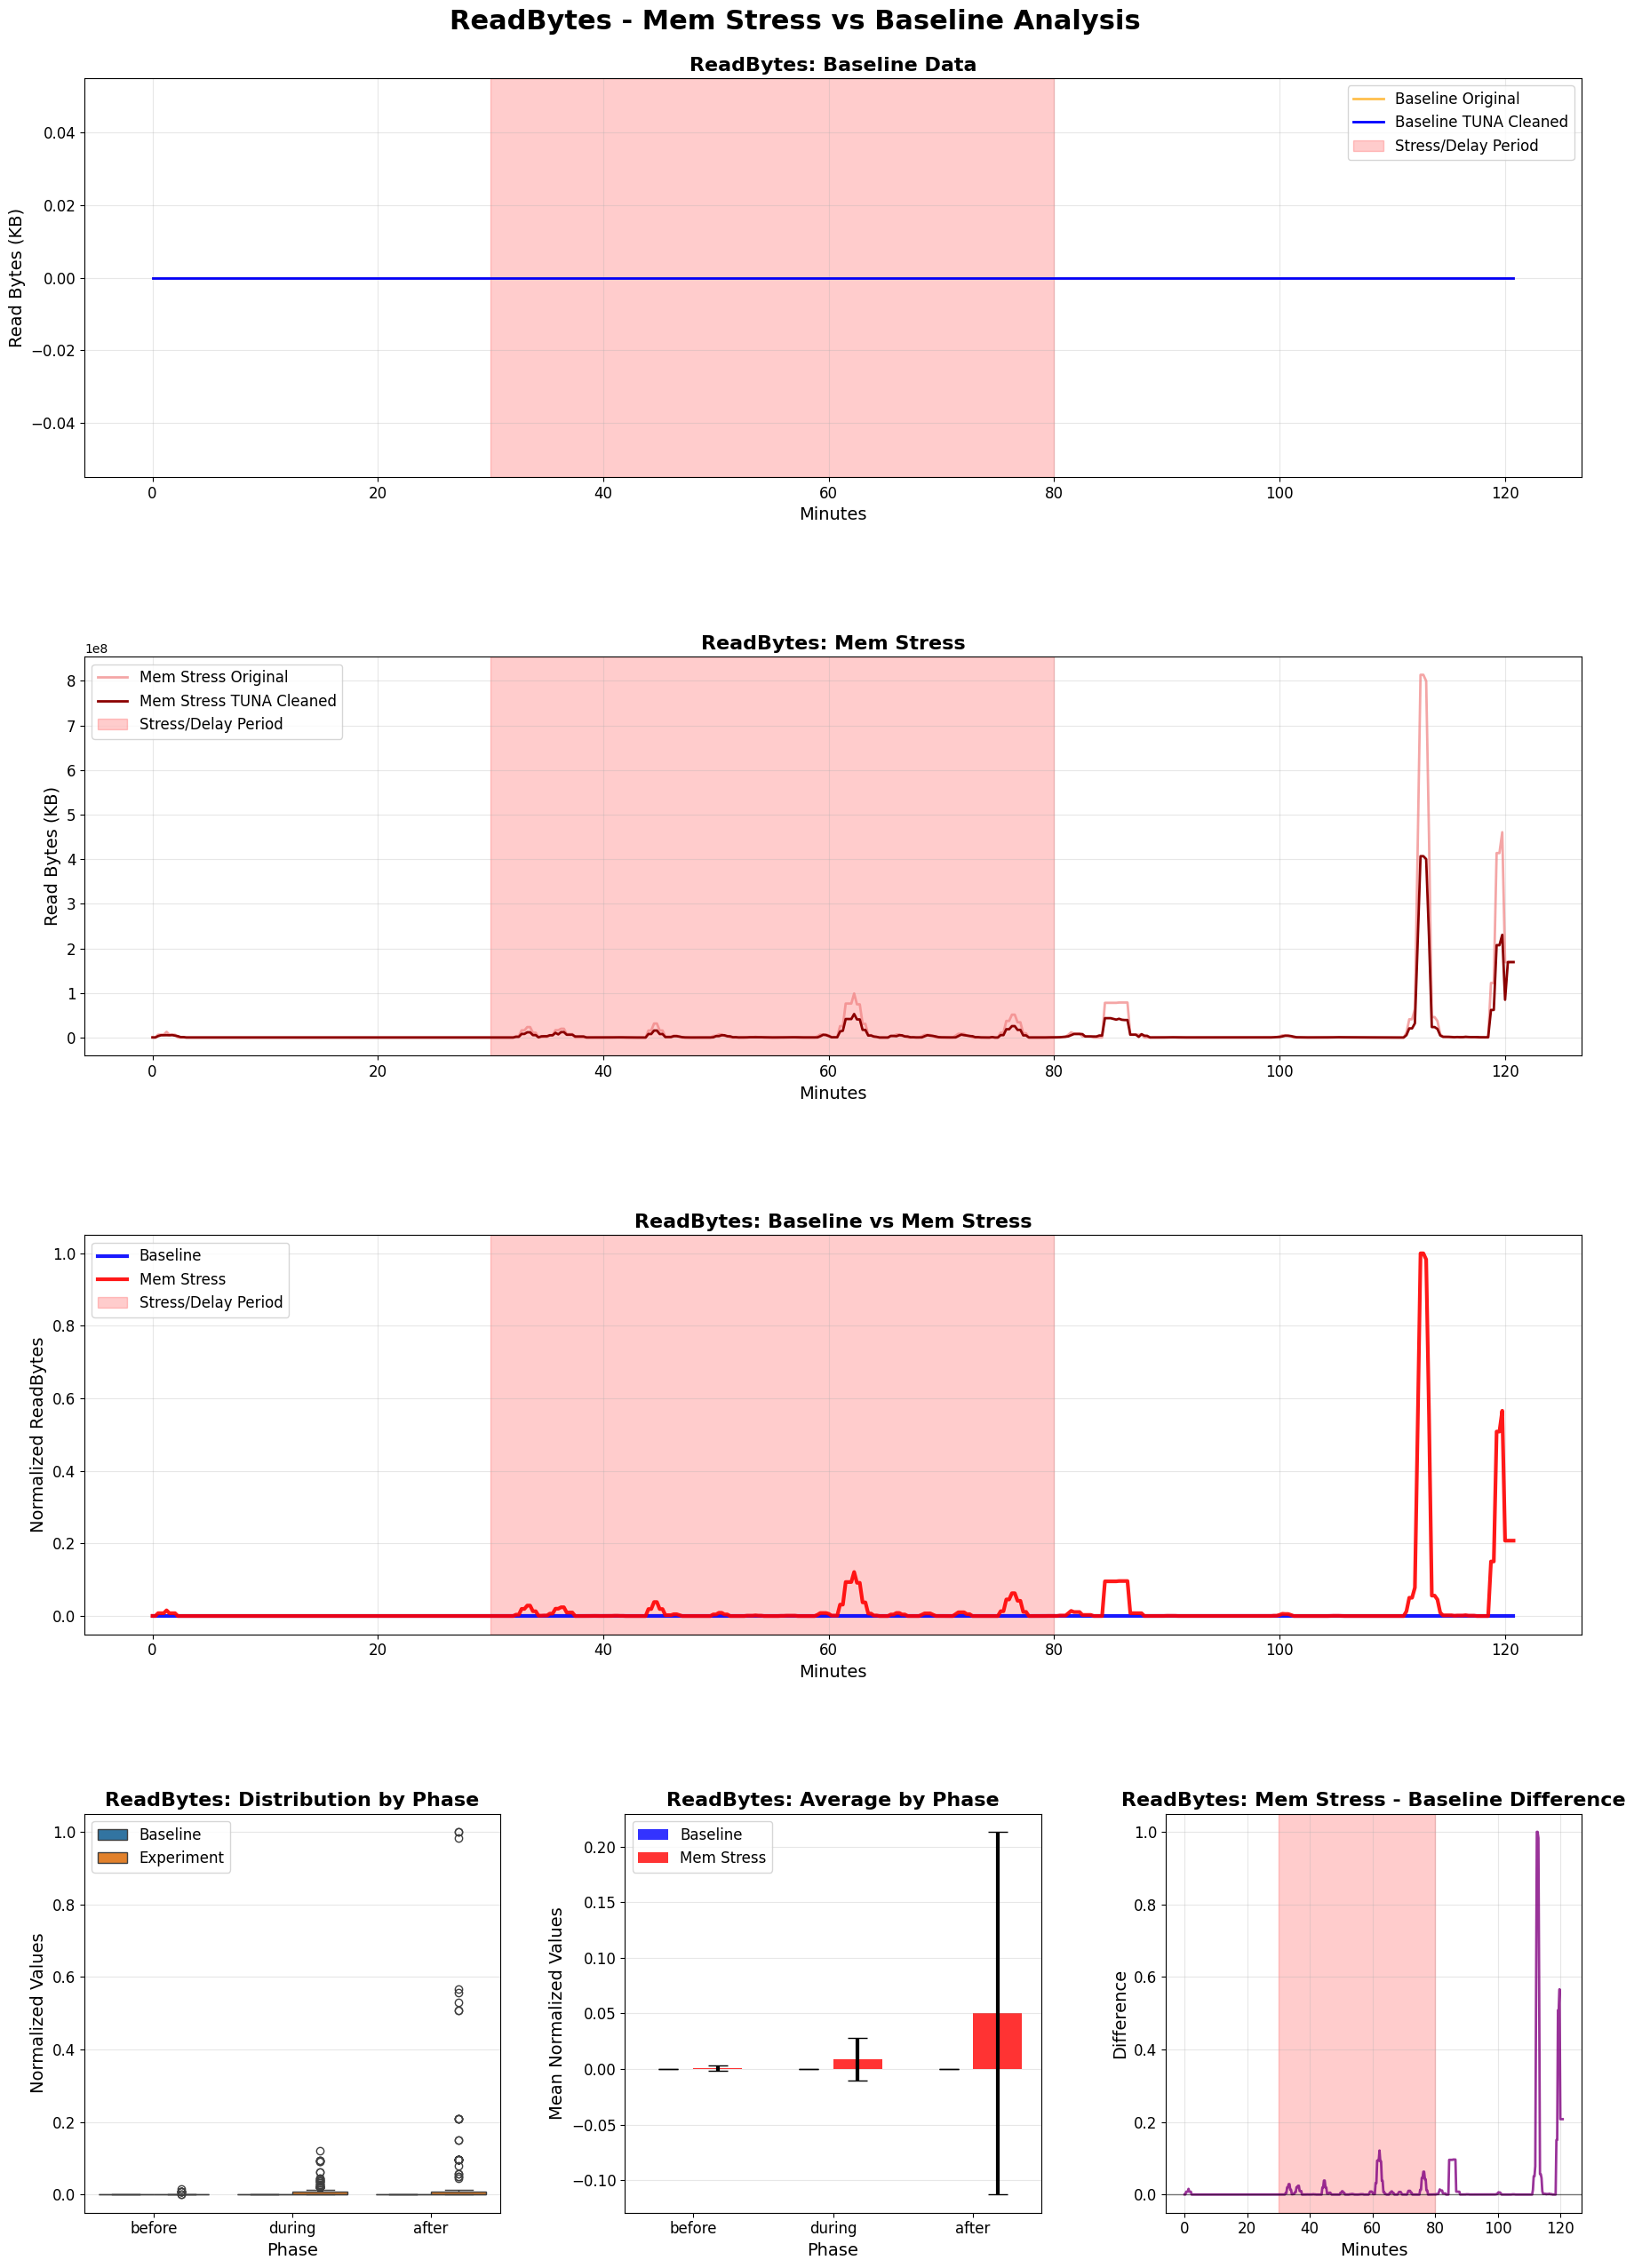


READBYTES - MEM STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  MEM STRESS: 296 outliers removed
    Noise Reduction: 48.0%, Correlation: 0.987
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

MEM STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0501  0.1630  0.0  1.0000
before  0.0005  0.0022  0.0  0.0157
during  0.0086  0.0194  0.0  0.1214

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.61, p=  0.0097 (SIGNIFICANT)
  DURING  : t= -6.32, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -3.92, p=  0.0001 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyze

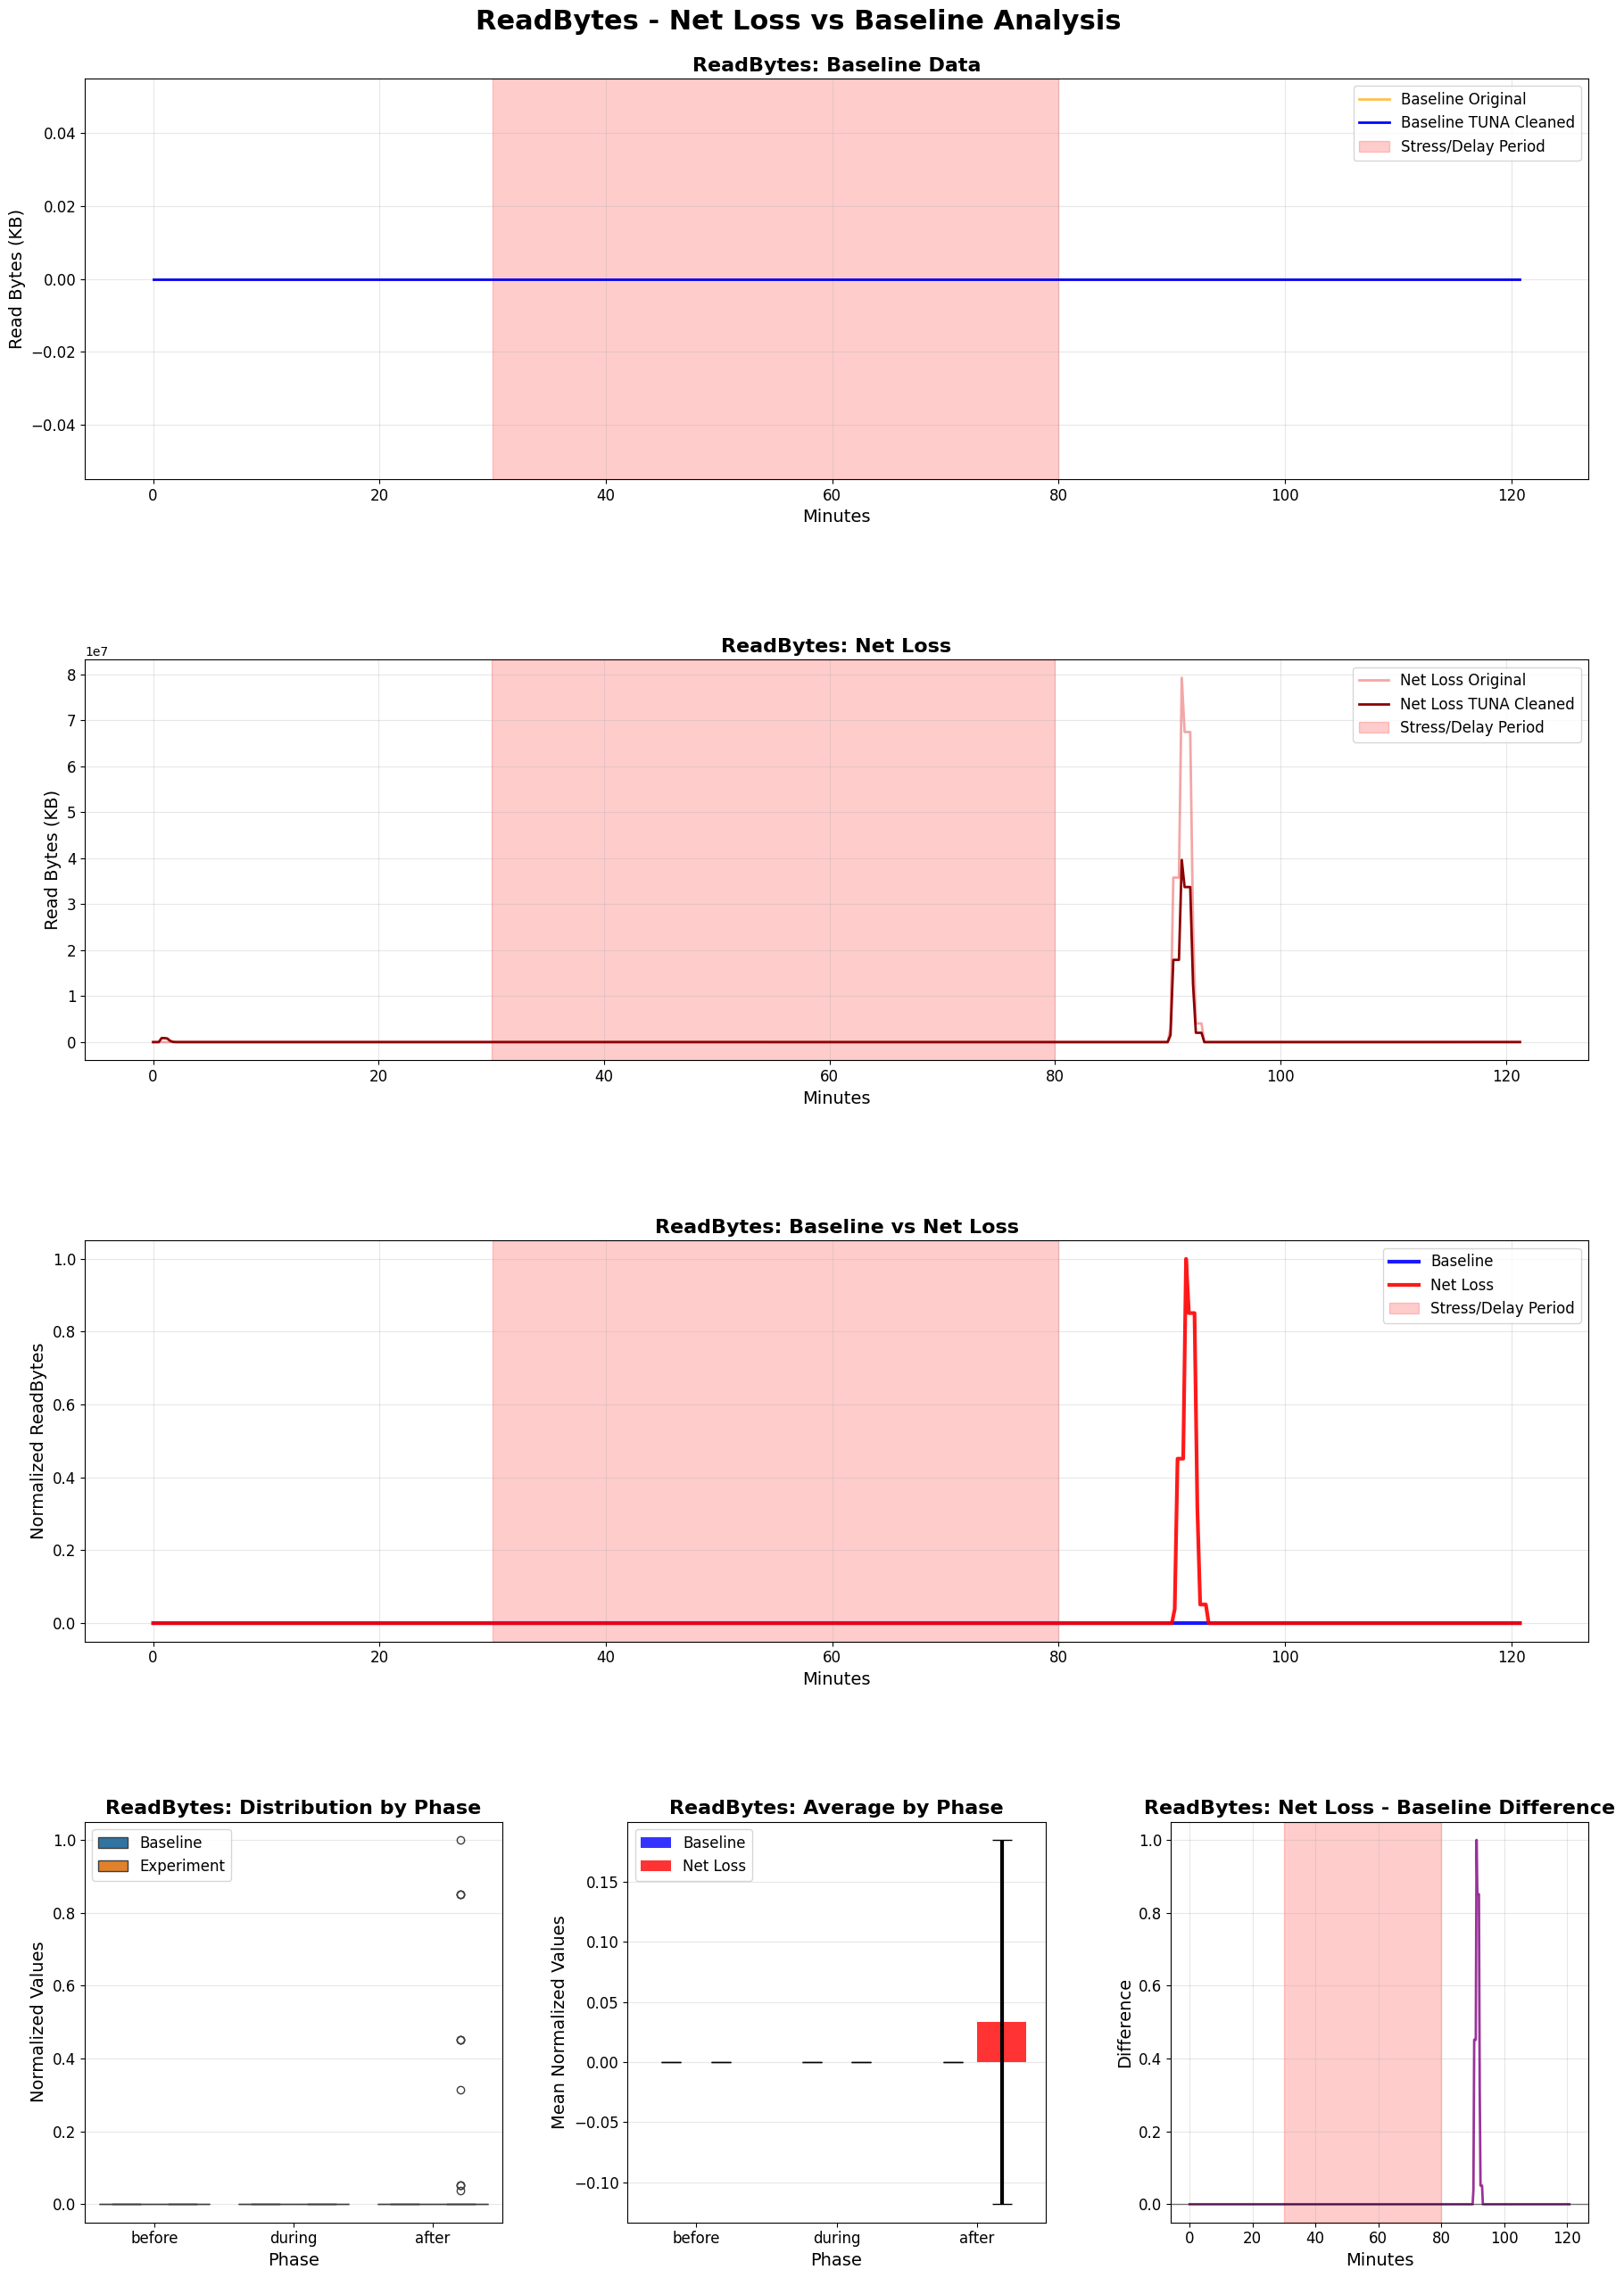


READBYTES - NET LOSS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  NET LOSS: 44 outliers removed
    Noise Reduction: 50.0%, Correlation: 1.000
  BASELINE: 0 outliers removed
    Noise Reduction: 0.0%, Correlation: 1.000

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0  0.0  0.0
before   0.0  0.0  0.0  0.0
during   0.0  0.0  0.0  0.0

NET LOSS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.0332  0.1514  0.0  1.0
before  0.0000  0.0000  0.0  0.0
during  0.0000  0.0000  0.0  0.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=   nan, p=     nan (NOT SIGNIFICANT)
  DURING  : t=   nan, p=     nan (NOT SIGNIFICANT)
  AFTER   : t= -2.80, p=  0.0054 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :   +0.00% (NO CHANGE)
  DURING  :   +0.00% (NO CHANGE)
  AFTER   :   +0.00% (NO CHANGE)

DISK I/O METRICS DETAILS:
  Metric: ReadBytes
  Metric type: Read Bytes (KB)
  Columns analyzed: ['openeuler-h

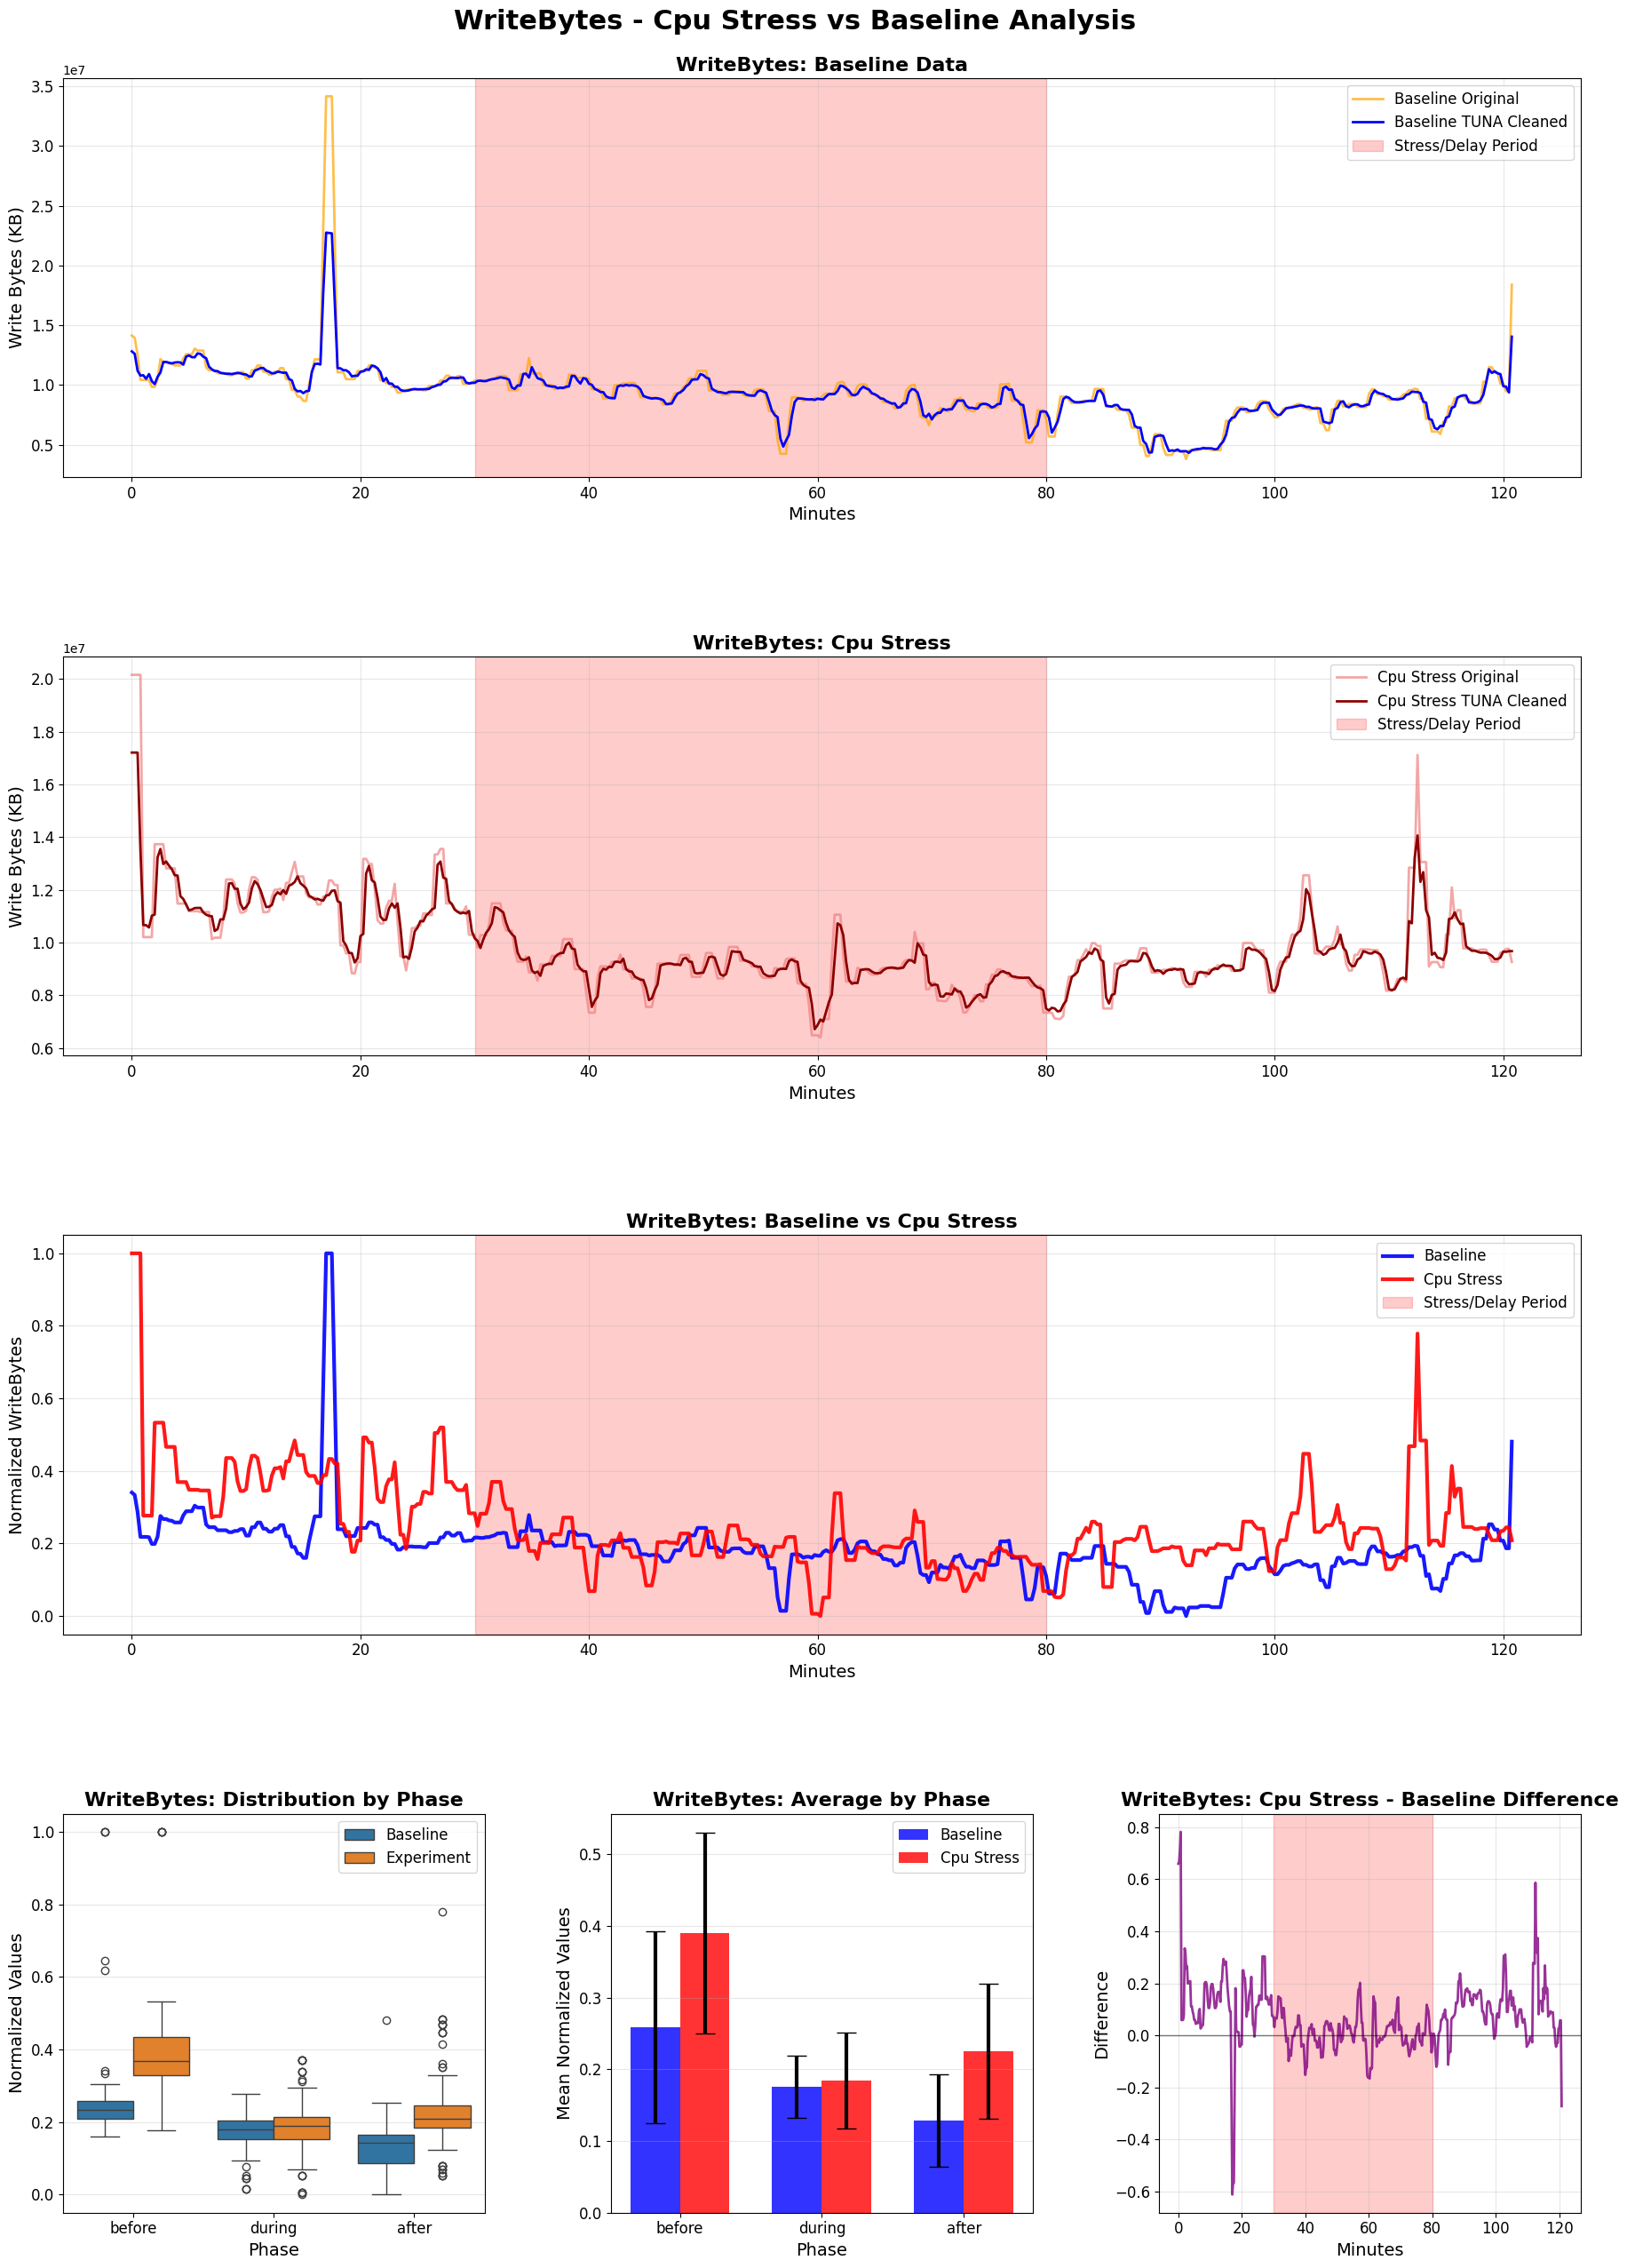


WRITEBYTES - CPU STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  CPU STRESS: 14 outliers removed
    Noise Reduction: 17.2%, Correlation: 0.944
  BASELINE: 46 outliers removed
    Noise Reduction: 26.4%, Correlation: 0.952

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1290  0.0643  0.0000  0.4808
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.2254  0.0940  0.0512  0.7789
before  0.3901  0.1401  0.1771  1.0000
during  0.1842  0.0671  0.0000  0.3699

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -7.44, p=  0.0000 (SIGNIFICANT)
  DURING  : t= -1.52, p=  0.1283 (NOT SIGNIFICANT)
  AFTER   : t=-10.81, p=  0.0000 (SIGNIFICANT)

CPU STRESS IMPACT:
  BEFORE  :  +51.01% (INCREASE)
  DURING  :   +4.89% (INCREASE)
  AFTER   :  +74.77% (INCREASE)

DISK I/O METRICS DETA

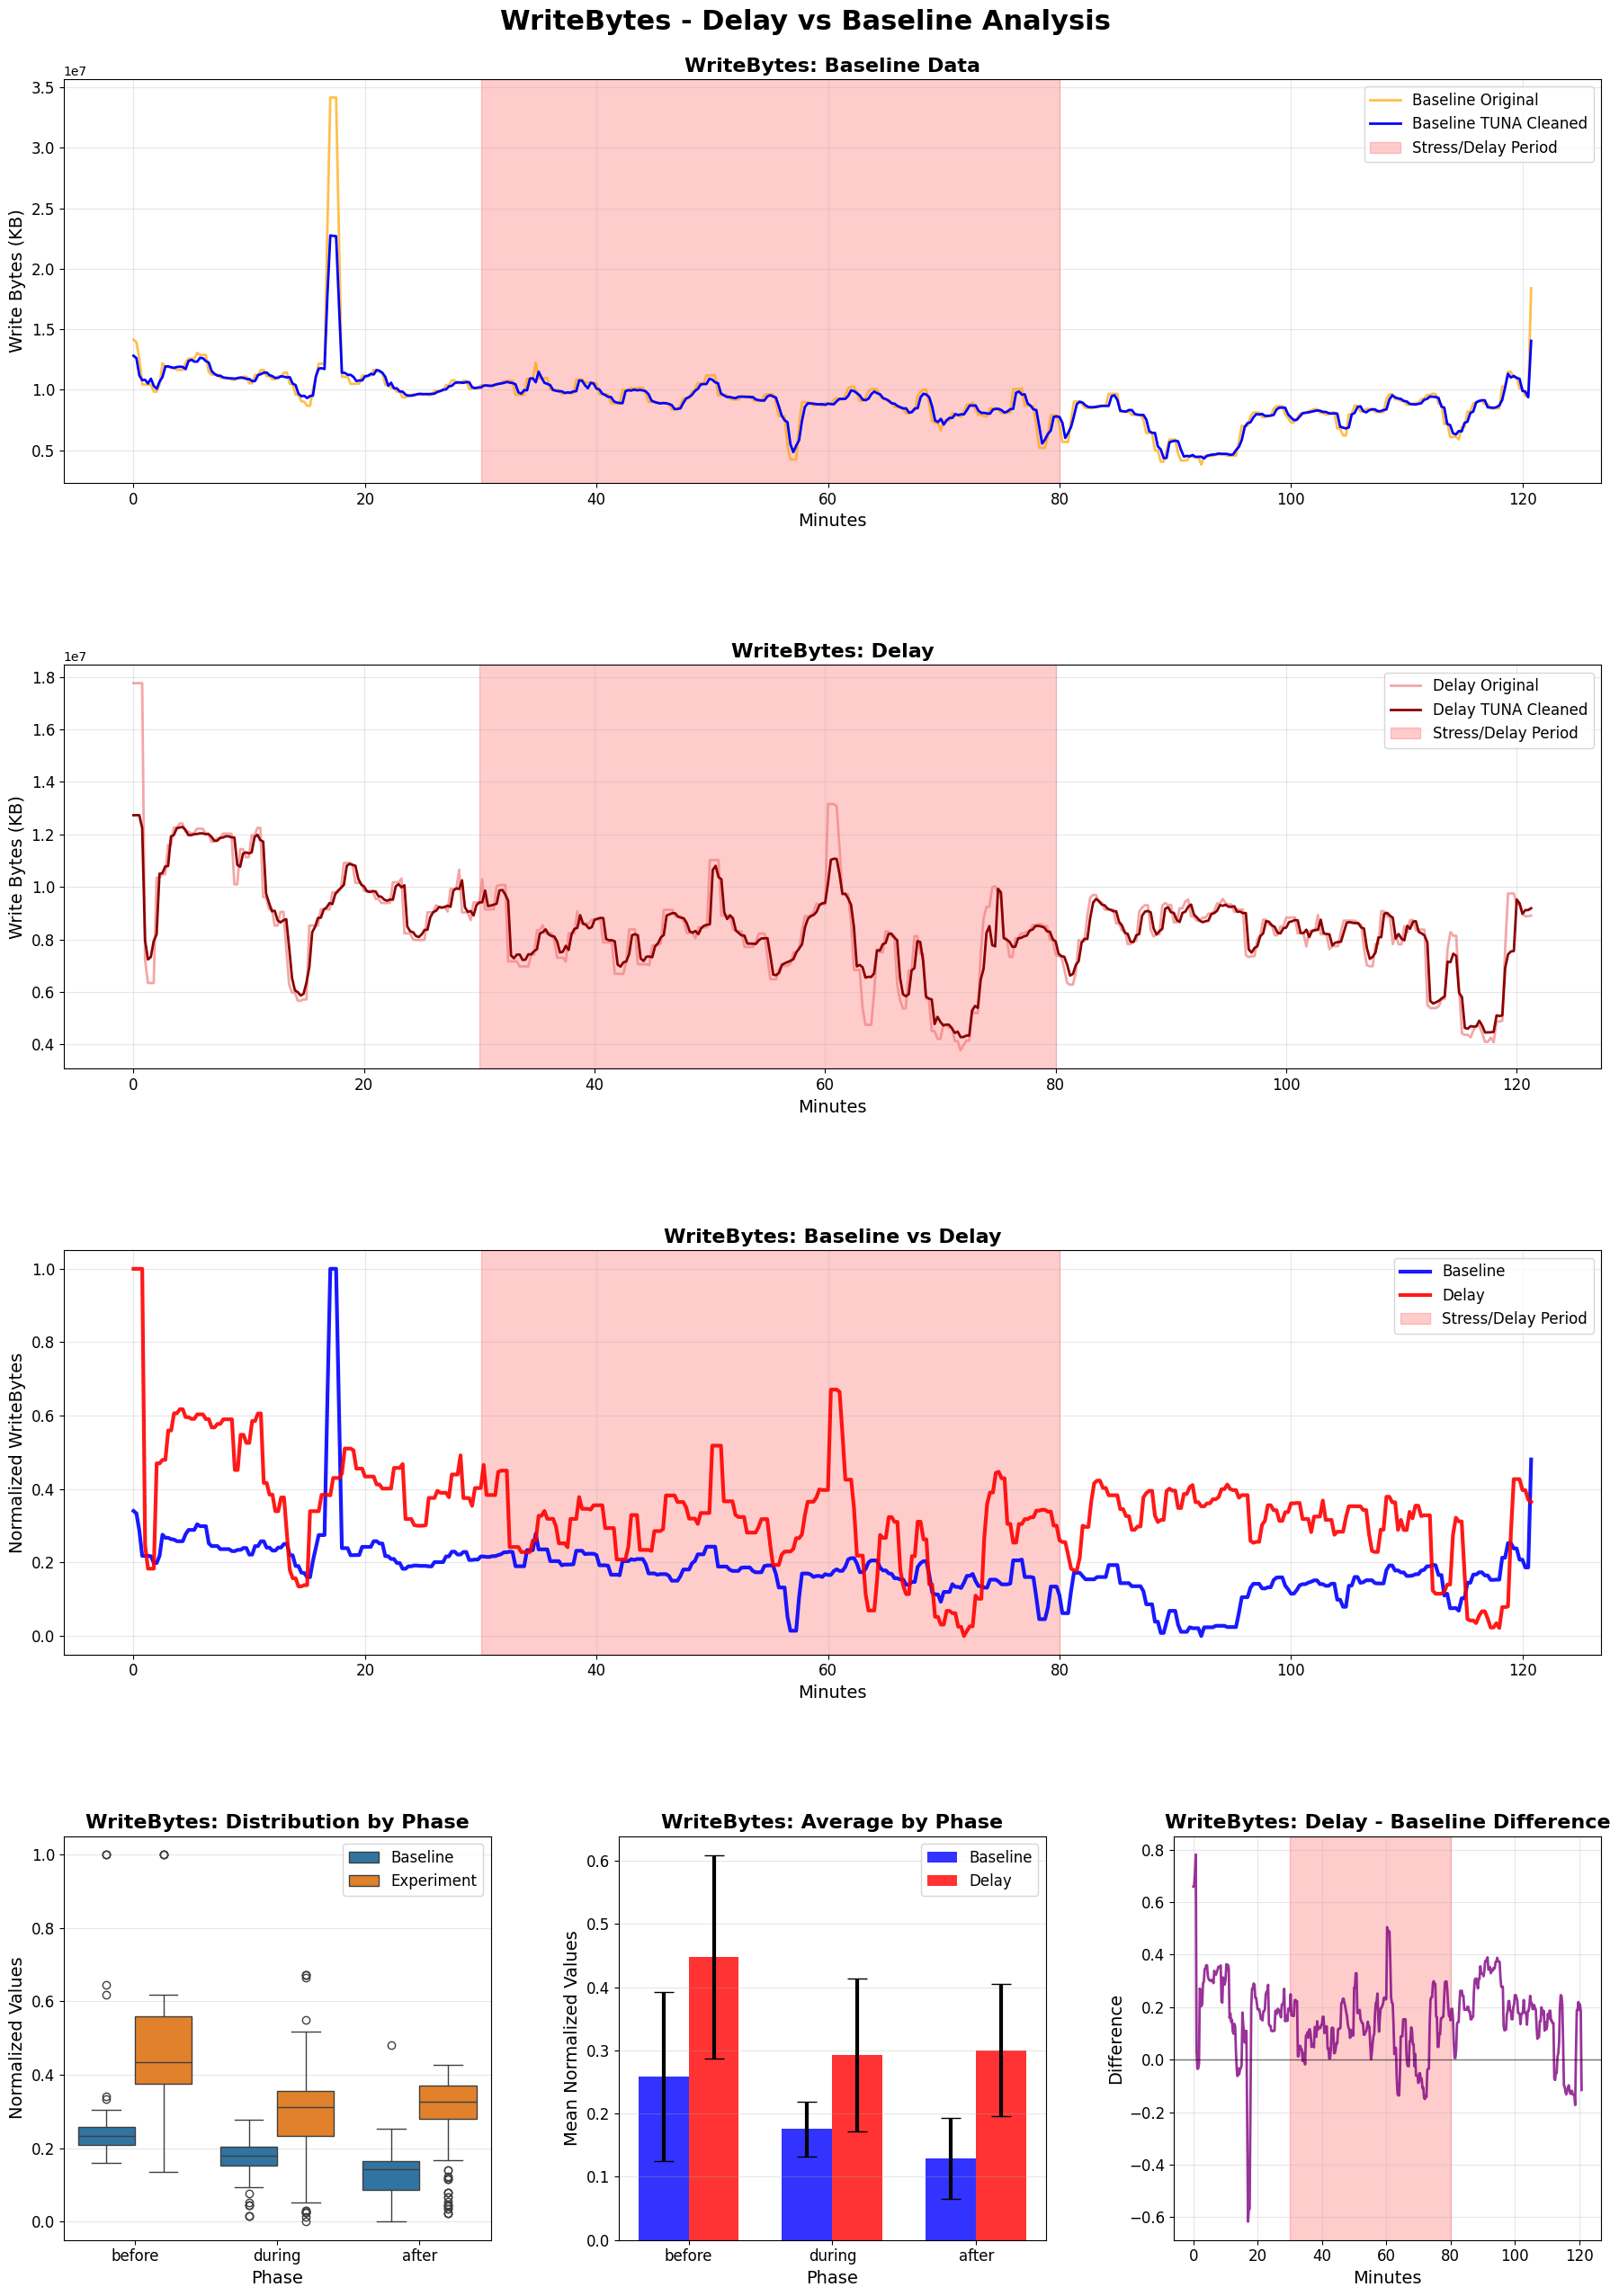


WRITEBYTES - DELAY VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  DELAY: 70 outliers removed
    Noise Reduction: 16.4%, Correlation: 0.928
  BASELINE: 46 outliers removed
    Noise Reduction: 26.4%, Correlation: 0.952

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1290  0.0643  0.0000  0.4808
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

DELAY STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3006  0.1048  0.0217  0.4272
before  0.4479  0.1609  0.1351  1.0000
during  0.2933  0.1212  0.0000  0.6710

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -9.92, p=  0.0000 (SIGNIFICANT)
  DURING  : t=-12.95, p=  0.0000 (SIGNIFICANT)
  AFTER   : t=-17.83, p=  0.0000 (SIGNIFICANT)

DELAY IMPACT:
  BEFORE  :  +73.39% (INCREASE)
  DURING  :  +67.01% (INCREASE)
  AFTER   : +133.08% (INCREASE)

DISK I/O METRICS DETAILS:
  Metric: WriteByte

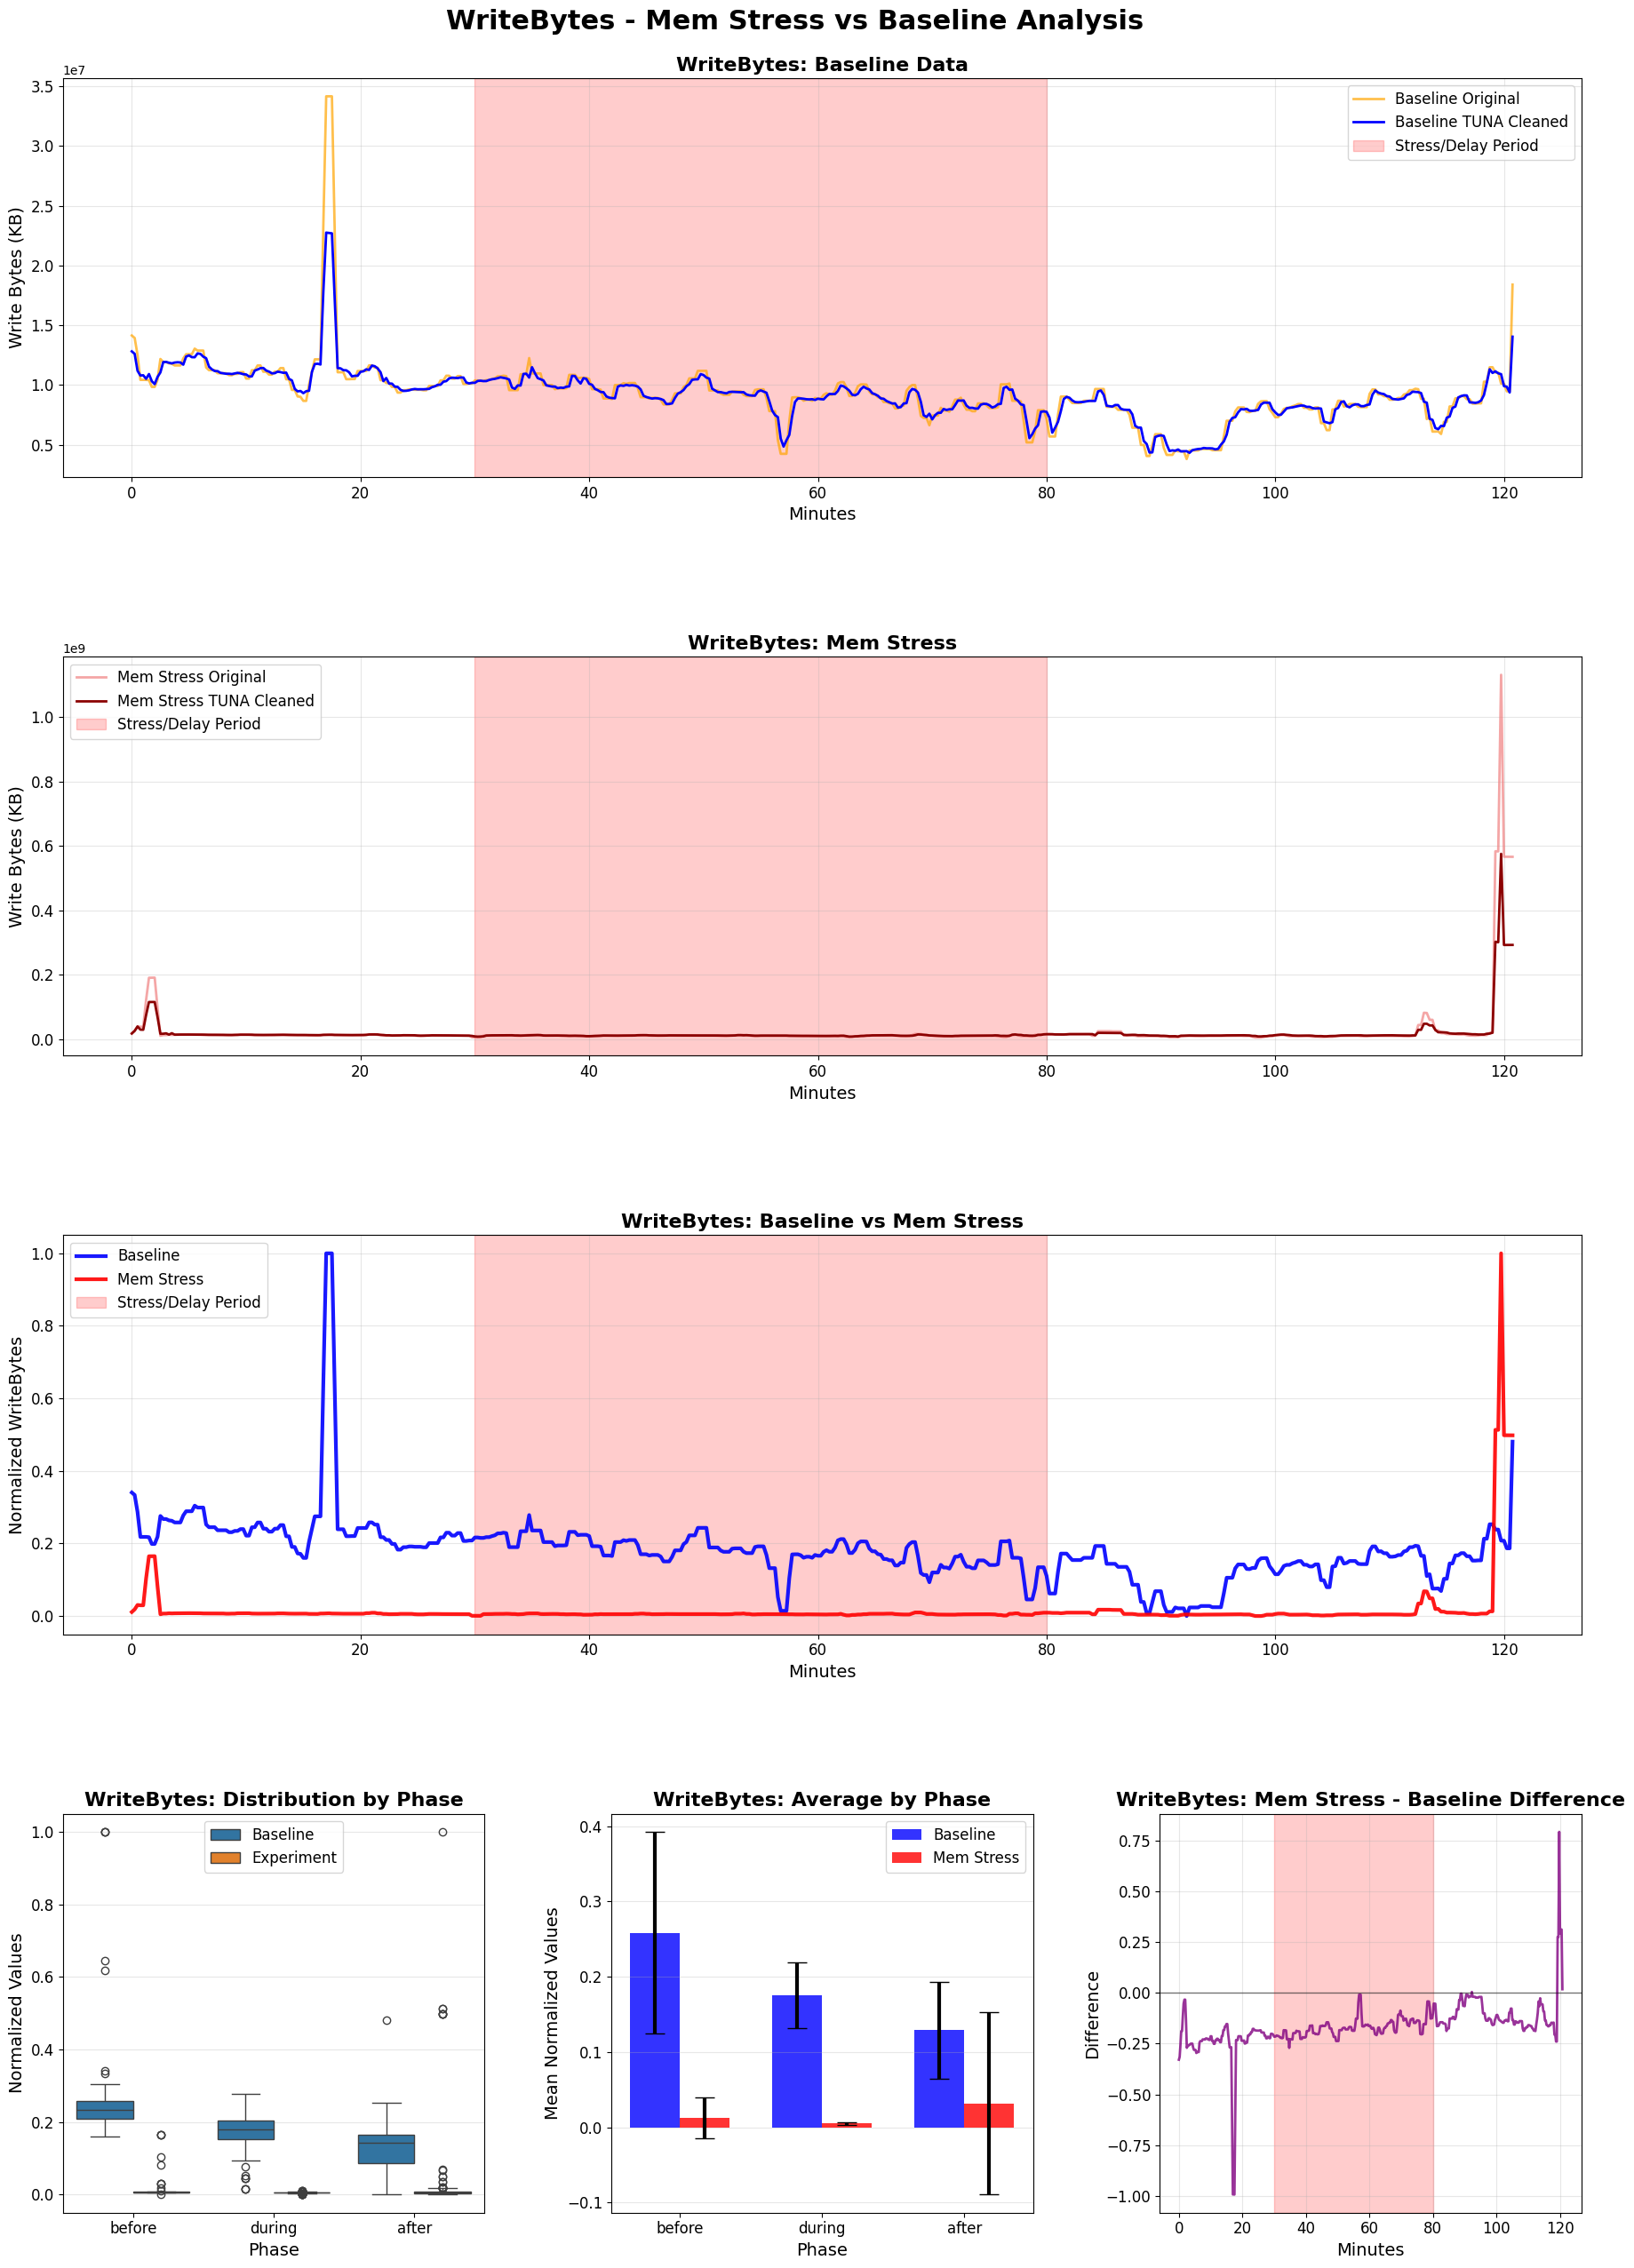


WRITEBYTES - MEM STRESS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  MEM STRESS: 111 outliers removed
    Noise Reduction: 49.2%, Correlation: 0.999
  BASELINE: 46 outliers removed
    Noise Reduction: 26.4%, Correlation: 0.952

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1290  0.0643  0.0000  0.4808
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

MEM STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0319  0.1212  0.0000  1.0000
before  0.0126  0.0272  0.0007  0.1650
during  0.0051  0.0014  0.0006  0.0098

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 19.68, p=  0.0000 (SIGNIFICANT)
  DURING  : t= 55.53, p=  0.0000 (SIGNIFICANT)
  AFTER   : t=  9.03, p=  0.0000 (SIGNIFICANT)

MEM STRESS IMPACT:
  BEFORE  :  -95.12% (DECREASE)
  DURING  :  -97.08% (DECREASE)
  AFTER   :  -75.23% (DECREASE)

DISK I/O METRICS DETAILS

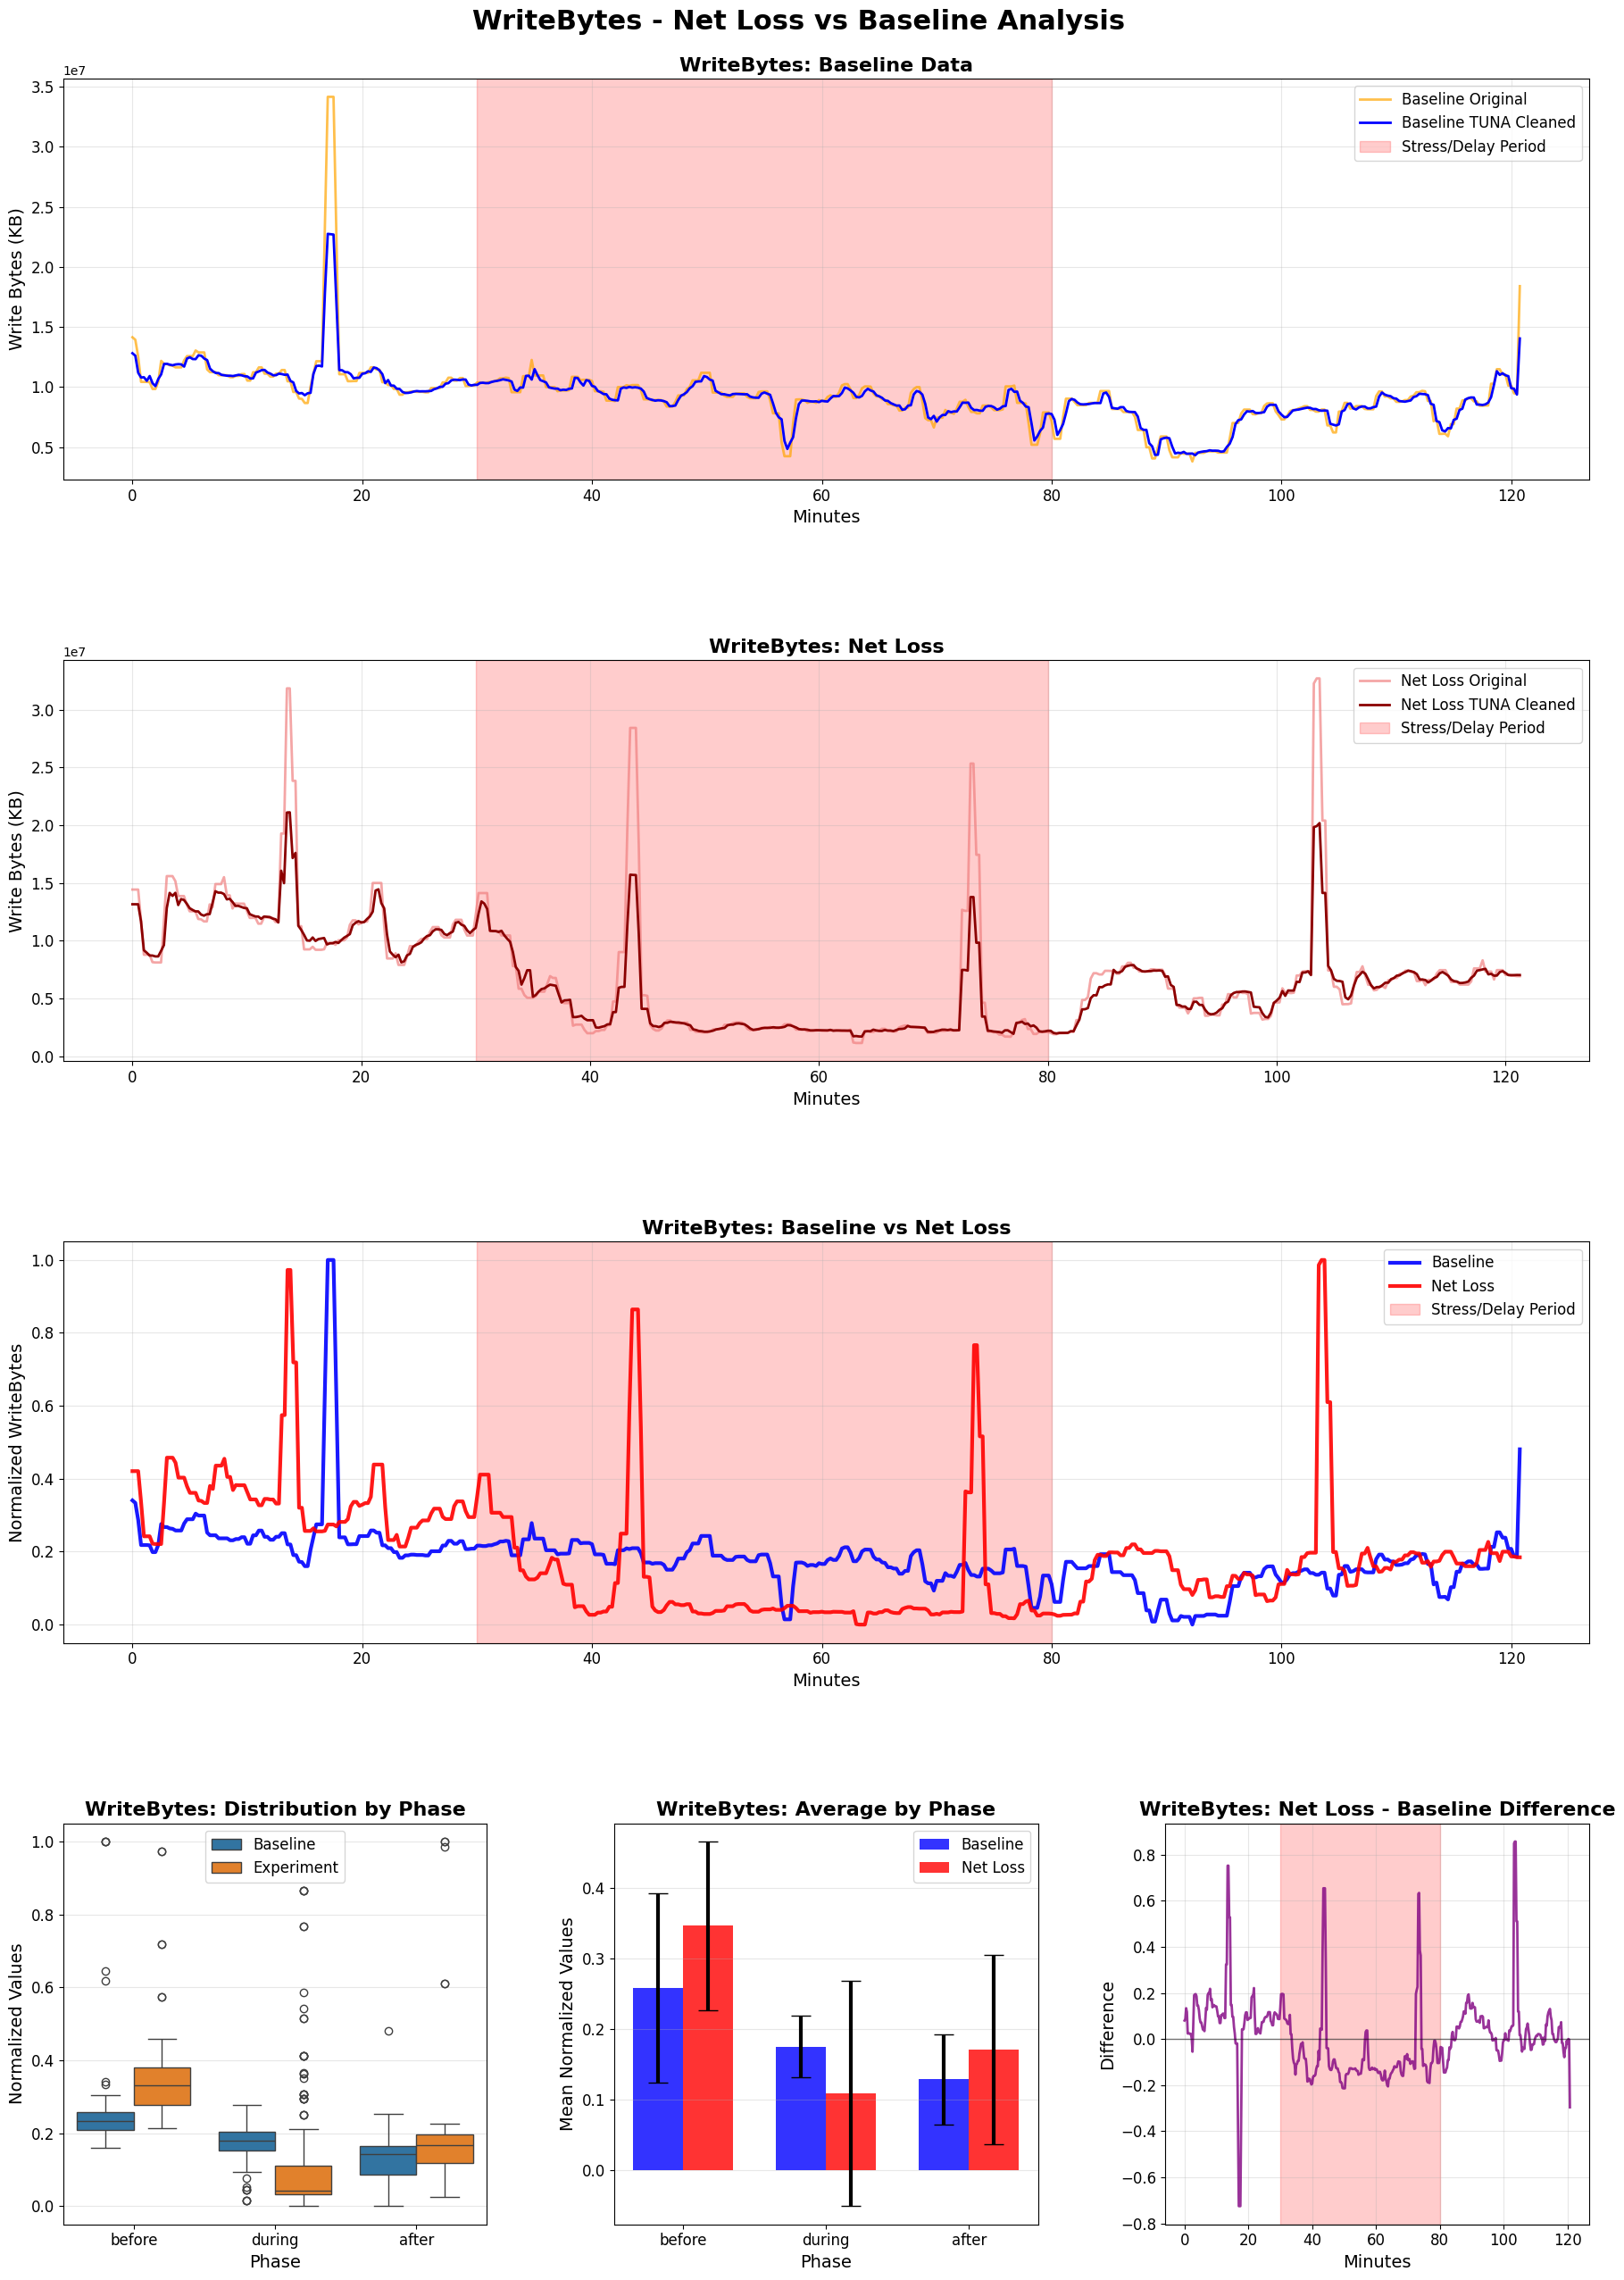


WRITEBYTES - NET LOSS VS BASELINE ANALYSIS

TUNA CLEANING SUMMARY:
  NET LOSS: 319 outliers removed
    Noise Reduction: 23.7%, Correlation: 0.940
  BASELINE: 46 outliers removed
    Noise Reduction: 26.4%, Correlation: 0.952

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1290  0.0643  0.0000  0.4808
before  0.2583  0.1341  0.1603  1.0000
during  0.1756  0.0435  0.0143  0.2784

NET LOSS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1713  0.1343  0.0241  1.0000
before  0.3467  0.1196  0.2141  0.9726
during  0.1089  0.1597  0.0000  0.8643

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -5.39, p=  0.0000 (SIGNIFICANT)
  DURING  : t=  5.71, p=  0.0000 (SIGNIFICANT)
  AFTER   : t= -3.63, p=  0.0003 (SIGNIFICANT)

NET LOSS IMPACT:
  BEFORE  :  +34.21% (INCREASE)
  DURING  :  -37.97% (DECREASE)
  AFTER   :  +32.86% (INCREASE)

DISK I/O METRICS DETAILS:
  Metr

In [3]:
def calculate_disk_values(df, metric_name):
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in df.columns if col not in exclude_cols]
    
    if metric_name == 'BlockLatency':
        return df[value_cols[0]].values
    else:
        return df[value_cols].sum(axis=1).values

def normalize_series(series):
    min_val = series.min()
    max_val = series.max()
    if max_val > min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series(np.zeros(len(series)), index=series.index)

def get_y_axis_label(metric_name):
    labels = {
        'BlockLatency': 'Block Latency (ms)',
        'ReadBytes': 'Read Bytes (KB)',
        'WriteBytes': 'Write Bytes (KB)',
        'DiskUtil': 'Disk Utilization (%)',
        'IOPS': 'I/O Operations per Second',
        'ThroughputRead': 'Read Throughput (MB/s)',
        'ThroughputWrite': 'Write Throughput (MB/s)'
    }
    return labels.get(metric_name, 'Disk I/O Value')

def analyze_and_plot_disk_comparison(metric_name, experiment_name, experiment_df, baseline_df, 
                                   tuna_results=None, delay_minutes=30, duration_minutes=50):
    
    # Calculate original values
    experiment_values = calculate_disk_values(experiment_df, metric_name)
    baseline_values = calculate_disk_values(baseline_df, metric_name)
    
    experiment_series = pd.Series(experiment_values, index=experiment_df.index)
    baseline_series = pd.Series(baseline_values, index=baseline_df.index)
    
    # Get TUNA cleaned data if available
    experiment_cleaned = None
    baseline_cleaned = None
    if tuna_results and metric_name in tuna_results:
        if experiment_name in tuna_results[metric_name]:
            experiment_cleaned = pd.Series(tuna_results[metric_name][experiment_name]['cleaned'])
        if 'baseline' in tuna_results[metric_name]:
            baseline_cleaned = pd.Series(tuna_results[metric_name]['baseline']['cleaned'])
    
    # Normalize series for comparison
    experiment_norm = normalize_series(experiment_series)
    baseline_norm = normalize_series(baseline_series)
    
    # Align data lengths
    min_length = min(len(experiment_norm), len(baseline_norm), len(experiment_df['Minutes']), len(baseline_df['Minutes']))
    
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm.iloc[:min_length],
        'Experiment': experiment_norm.iloc[:min_length],
        'Minutes': experiment_df['Minutes'].iloc[:min_length],
        'Baseline_Minutes': baseline_df['Minutes'].iloc[:min_length]
    })
    
    df_combined['difference'] = df_combined['Experiment'] - df_combined['Baseline']
    
    # Define phases
    df_combined['phase'] = 'before'
    df_combined.loc[(df_combined['Minutes'] >= delay_minutes) & 
                   (df_combined['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'
    df_combined.loc[df_combined['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after'
    
    # Calculate statistics
    stats_baseline = df_combined.groupby('phase')['Baseline'].agg(['mean', 'std', 'min', 'max'])
    stats_experiment = df_combined.groupby('phase')['Experiment'].agg(['mean', 'std', 'min', 'max'])
    
    # Statistical tests
    t_tests = {}
    available_phases = stats_baseline.index.tolist()
    
    for phase in ['before', 'during', 'after']:
        if phase in available_phases:
            data = df_combined[df_combined['phase'] == phase]
            if len(data) > 1:
                t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['Experiment'].dropna())
                t_tests[phase] = {'t': t_stat, 'p': p_value}
            else:
                t_tests[phase] = {'t': 0, 'p': 1}
        else:
            t_tests[phase] = {'t': 0, 'p': 1, 'note': 'Phase not present in data'}
    
    # Calculate impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        if phase in available_phases:
            baseline_mean = stats_baseline.loc[phase, 'mean']
            experiment_mean = stats_experiment.loc[phase, 'mean']
            if baseline_mean != 0:
                impact[phase] = ((experiment_mean - baseline_mean) / baseline_mean) * 100
            else:
                impact[phase] = 0
        else:
            impact[phase] = 0
    
    # Create plots
    fig = plt.figure(figsize=(18, 26))
    
    y_label = get_y_axis_label(metric_name)
    
    # Plot 1: Baseline Data (Original vs TUNA Cleaned)
    plt.subplot(4, 1, 1)
    plt.plot(baseline_df['Minutes'], baseline_series, 
             label='Baseline Original', color='orange', alpha=0.7, linewidth=2)
    
    if baseline_cleaned is not None:
        plt.plot(baseline_df['Minutes'].iloc[:len(baseline_cleaned)], baseline_cleaned, 
                 label='Baseline TUNA Cleaned', linewidth=2, color='blue')
    else:
        plt.plot(baseline_df['Minutes'], baseline_series, 
                 label='Baseline', linewidth=2, color='blue')
    
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f'{metric_name}: Baseline Data', fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Plot 2: Experiment Data (Original vs TUNA Cleaned)
    plt.subplot(4, 1, 2)
    plt.plot(experiment_df['Minutes'], experiment_series, 
             label=f'{experiment_name.replace("_", " ").title()} Original', 
             alpha=0.7, color='lightcoral', linewidth=2)
    
    if experiment_cleaned is not None:
        plt.plot(experiment_df['Minutes'].iloc[:len(experiment_cleaned)], experiment_cleaned, 
                 label=f'{experiment_name.replace("_", " ").title()} TUNA Cleaned', 
                 linewidth=2, color='darkred')
    else:
        plt.plot(experiment_df['Minutes'], experiment_series, 
                 label=f'{experiment_name.replace("_", " ").title()}', 
                 linewidth=2, color='darkred')

    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f'{metric_name}: {experiment_name.replace("_", " ").title()}', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Plot 3: Normalized Comparison
    plt.subplot(4, 1, 3)
    plt.plot(df_combined['Minutes'], df_combined['Baseline'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(df_combined['Minutes'], df_combined['Experiment'], 
             label=f'{experiment_name.replace("_", " ").title()}', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Stress/Delay Period")
    plt.title(f"{metric_name}: Baseline vs {experiment_name.replace('_', ' ').title()}", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Minutes", fontsize=14)
    plt.ylabel(f"Normalized {metric_name}", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Plot 4: Distribution by Phase (Box Plot)
    plt.subplot(4, 3, 10)
    box_data = pd.melt(df_combined[['Baseline', 'Experiment', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{metric_name}: Distribution by Phase', fontsize=16, fontweight='bold')
    plt.xlabel('Phase', fontsize=14)
    plt.ylabel('Normalized Values', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Plot 5: Average by Phase (Bar Chart)
    plt.subplot(4, 3, 11)
    phases_to_plot = [p for p in ['before', 'during', 'after'] if p in available_phases]
    
    if len(phases_to_plot) > 0:
        x = np.arange(len(phases_to_plot))
        width = 0.35
        
        baseline_means = [stats_baseline.loc[p, 'mean'] for p in phases_to_plot]
        baseline_stds = [stats_baseline.loc[p, 'std'] for p in phases_to_plot]
        experiment_means = [stats_experiment.loc[p, 'mean'] for p in phases_to_plot]
        experiment_stds = [stats_experiment.loc[p, 'std'] for p in phases_to_plot]
        
        bars1 = plt.bar(x - width/2, baseline_means, width, 
                       label='Baseline', alpha=0.8, color='blue')
        bars2 = plt.bar(x + width/2, experiment_means, width, 
                       label=f'{experiment_name.replace("_", " ").title()}', alpha=0.8, color='red')
        
        plt.errorbar(x - width/2, baseline_means, yerr=baseline_stds, 
                    fmt='none', ecolor='black', capsize=8, linewidth=3)
        plt.errorbar(x + width/2, experiment_means, yerr=experiment_stds, 
                    fmt='none', ecolor='black', capsize=8, linewidth=3)
        
        plt.xticks(x, phases_to_plot)
    else:
        plt.text(0.5, 0.5, 'No phase data available', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
    
    plt.title(f'{metric_name}: Average by Phase', fontsize=16, fontweight='bold')
    plt.xlabel('Phase', fontsize=14)
    plt.ylabel('Mean Normalized Values', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Plot 6: Difference Plot
    plt.subplot(4, 3, 12)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{metric_name}: {experiment_name.replace("_", " ").title()} - Baseline Difference', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Minutes', fontsize=14)
    plt.ylabel('Difference', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.suptitle(f'{metric_name} - {experiment_name.replace("_", " ").title()} vs Baseline Analysis', 
                fontsize=22, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.45, wspace=0.3)
    plt.show()
    
    # Print analysis summary
    print(f"\n{'='*80}")
    print(f"{metric_name.upper()} - {experiment_name.upper().replace('_', ' ')} VS BASELINE ANALYSIS")
    print(f"{'='*80}")
    
    # TUNA cleaning summary (if available)
    if tuna_results and metric_name in tuna_results:
        print(f"\nTUNA CLEANING SUMMARY:")
        if experiment_name in tuna_results[metric_name]:
            exp_stats = tuna_results[metric_name][experiment_name]['stats']
            print(f"  {experiment_name.upper().replace('_', ' ')}: {exp_stats['outliers']} outliers removed")
            print(f"    Noise Reduction: {exp_stats['noise_reduction']:.1f}%, Correlation: {exp_stats['correlation']:.3f}")
        
        if 'baseline' in tuna_results[metric_name]:
            base_stats = tuna_results[metric_name]['baseline']['stats']
            print(f"  BASELINE: {base_stats['outliers']} outliers removed")
            print(f"    Noise Reduction: {base_stats['noise_reduction']:.1f}%, Correlation: {base_stats['correlation']:.3f}")

    print(f"\nBASELINE STATISTICS BY PHASE:")
    if len(stats_baseline) > 0:
        print(stats_baseline.round(4))
    else:
        print("  No phase data available")

    print(f"\n{experiment_name.upper().replace('_', ' ')} STATISTICS BY PHASE:")
    if len(stats_experiment) > 0:
        print(stats_experiment.round(4))
    else:
        print("  No phase data available")

    print(f"\nSTATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        if 'note' in test:
            print(f"  {phase.upper():8}: {test['note']}")
        else:
            sig = "SIGNIFICANT" if test['p'] < 0.05 else "NOT SIGNIFICANT"
            print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")

    print(f"\n{experiment_name.upper().replace('_', ' ')} IMPACT:")
    for phase, change in impact.items():
        if change == 0 and phase not in available_phases:
            print(f"  {phase.upper():8}: Phase not present in data")
        else:
            direction = "INCREASE" if change > 0 else "DECREASE" if change < 0 else "NO CHANGE"
            print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")

    value_cols = [col for col in experiment_df.columns if col not in ['Time', 'Minutes', 'source']]
    print(f"\nDISK I/O METRICS DETAILS:")
    print(f"  Metric: {metric_name}")
    print(f"  Metric type: {y_label}")
    print(f"  Columns analyzed: {value_cols}")
    print(f"  Data points analyzed: {len(df_combined)}")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_experiment': stats_experiment,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'tuna_info': {
            'experiment_cleaned': experiment_cleaned is not None,
            'baseline_cleaned': baseline_cleaned is not None
        }
    }

def run_comprehensive_disk_analysis(all_datasets, tuna_results=None):
    """Run comprehensive disk analysis using pre-computed TUNA results"""
    analysis_results = {}
    
    for metric_name, experiments in all_datasets.items():
        print(f"\n🔍 Analyzing {metric_name}...")
        analysis_results[metric_name] = {}
        
        baseline_df = experiments['baseline']
        
        for experiment_name, experiment_df in experiments.items():
            if experiment_name != 'baseline':                
                result = analyze_and_plot_disk_comparison(
                    metric_name=metric_name,
                    experiment_name=experiment_name,
                    experiment_df=experiment_df,
                    baseline_df=baseline_df,
                    tuna_results=tuna_results  # Pass pre-computed TUNA results
                )
                
                analysis_results[metric_name][experiment_name] = result
    
    return analysis_results

def export_tuna_data_to_csv(tuna_results, export_dir="../../noise_reduction_data"):    
    """Export TUNA results to CSV (from pre-computed results)"""
    export_data = []
    
    for metric_name, metric_data in tuna_results.items():
        for experiment_name, experiment_data in metric_data.items():
            if 'stats' in experiment_data:
                stats = experiment_data['stats']
                
                export_data.append({
                    'experiment_name': experiment_name,
                    'metric': metric_name,
                    'noise_reduction_pct': stats.get('noise_reduction', 0.0),
                    'correlation': stats.get('correlation', 1.0),
                    'outliers_removed': stats.get('outliers', 0),
                })
    
    csv_filename = f"customers_tuna_IO.csv"
    csv_path = os.path.join(export_dir, csv_filename)
    
    df_simple = pd.DataFrame(export_data)
    df_simple.to_csv(csv_path, index=False)

    return csv_path


disk_results = run_comprehensive_disk_analysis(all_datasets, tuna_results)